## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna
# !apt install -y libgl1-mesa-glx
# !pip install albumentations

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'
# model_name = 'convnextv2_base.fcmae_ft_in22k_in1k_384'
# model_name = 'vit_base_patch16_clip_384.laion2b_ft_in12k_in1k' # openclip
# model_name = 'vit_base_patch16_384.augreg_in1k' # augreg
# model_name = 'eva02_enormous_patch14_plus_clip_224.laion2b_s9b_b144k' # eva-02 멀티모달
# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용
# model_name = 'vit_base_patch14_reg4_dinov2.lvd142m' # dinov2 reg4

# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용

# training config
img_size = 512
LR = 2e-4
EPOCHS = 100
BATCH_SIZE = 10
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [10]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 전체 학습 데이터 로드
train_df = pd.read_csv("/root/home/cv_contest/CV_data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "/root/home/cv_contest/CV_data/train",
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "/root/home/cv_contest/CV_data/train",
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        start_time = time.time()
        
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f} | "
              f"LR: {current_lr:.2e} | "
              f"Time: {epoch_time:.1f}s")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # 최고 성능 모델을 파일로 저장
            model_path = f'BH_512_base_best_model_fold_{fold+1}.pth'
            torch.save(best_model, model_path)
            print(f"새로운 최고 성능! F1: {best_val_f1:.4f} - 모델 저장: {model_path}")
            
            # Best 모델로 클래스별 정확도 계산
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도 계산
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()

    # 현재 fold 결과 저장
    fold_result = {
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'final_train_f1': train_ret['train_f1'],
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset),
        'epochs_trained': EPOCHS,
        'model_path': f'BH_512_base_best_model_fold_{fold+1}.pth'
    }
    
    fold_results.append(fold_result)
    fold_models.append(best_model)
    fold_class_accuracies.append(fold_class_acc)
    
    print(f"\nFold {fold + 1} 완료!")
    print(f"최고 Validation F1: {best_val_f1:.4f}")
    print(f"학습된 에폭: {EPOCHS}/{EPOCHS}")
    print(f"모델 저장 위치: BH_512_base_best_model_fold_{fold+1}.pth")
    
    # 메모리 정리
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: F1={result['best_val_f1']:.4f} "
          f"(epochs: {result['epochs_trained']}) "
          f"- {result['model_path']}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

# 저장된 모델 파일 리스트 출력
print(f"\n저장된 모델 파일들:")
for i in range(N_FOLDS):
    model_file = f'BH_512_base_best_model_fold_{i+1}.pth'
    if os.path.exists(model_file):
        print(f"  ✓ {model_file}")
    else:
        print(f"  ✗ {model_file} (없음)")

# 클래스별 평균 정확도 계산
if fold_class_accuracies:
    print(f"\n클래스별 평균 정확도 (전체 fold):")
    for class_id in range(17):
        class_accs = []
        for fold_acc in fold_class_accuracies:
            if class_id in fold_acc:
                class_accs.append(fold_acc[class_id])
        
        if class_accs:
            mean_acc = np.mean(class_accs)
            std_acc = np.std(class_accs)
            print(f"  Class {class_id:2d}: {mean_acc:.3f} ± {std_acc:.3f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314

Epoch 1/100


Val Loss: 1.4162: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Epoch  1 | Train Loss: 1.7730 | Train F1: 0.4472 | Val Loss: 0.8851 | Val F1: 0.8036 | LR: 2.00e-04 | Time: 82.1s
새로운 최고 성능! F1: 0.8036 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 2/100


Val Loss: 0.8446: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch  2 | Train Loss: 1.0022 | Train F1: 0.7014 | Val Loss: 0.7424 | Val F1: 0.8336 | LR: 2.00e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.8336 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 3/100


Val Loss: 0.5585: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch  3 | Train Loss: 0.8768 | Train F1: 0.7228 | Val Loss: 0.6196 | Val F1: 0.8811 | LR: 2.00e-04 | Time: 27.3s
새로운 최고 성능! F1: 0.8811 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 4/100


Val Loss: 0.5857: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch  4 | Train Loss: 0.8156 | Train F1: 0.7902 | Val Loss: 0.5282 | Val F1: 0.8956 | LR: 1.99e-04 | Time: 27.7s
새로운 최고 성능! F1: 0.8956 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 5/100


Val Loss: 0.6976: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch  5 | Train Loss: 0.7618 | Train F1: 0.7853 | Val Loss: 0.5681 | Val F1: 0.8720 | LR: 1.99e-04 | Time: 28.2s

Epoch 6/100


Val Loss: 0.3719: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch  6 | Train Loss: 0.6963 | Train F1: 0.7996 | Val Loss: 0.4939 | Val F1: 0.9064 | LR: 1.98e-04 | Time: 28.0s
새로운 최고 성능! F1: 0.9064 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 7/100


Val Loss: 0.4411: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch  7 | Train Loss: 0.6368 | Train F1: 0.8466 | Val Loss: 0.5073 | Val F1: 0.9300 | LR: 1.98e-04 | Time: 27.2s
새로운 최고 성능! F1: 0.9300 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 8/100


Val Loss: 0.4537: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch  8 | Train Loss: 0.6256 | Train F1: 0.8682 | Val Loss: 0.5234 | Val F1: 0.9352 | LR: 1.97e-04 | Time: 27.0s
새로운 최고 성능! F1: 0.9352 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 9/100


Val Loss: 0.5636: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch  9 | Train Loss: 0.6626 | Train F1: 0.8130 | Val Loss: 0.4926 | Val F1: 0.9294 | LR: 1.96e-04 | Time: 27.5s

Epoch 10/100


Val Loss: 0.5162: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 10 | Train Loss: 0.6671 | Train F1: 0.8249 | Val Loss: 0.4718 | Val F1: 0.9419 | LR: 1.95e-04 | Time: 27.7s
새로운 최고 성능! F1: 0.9419 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 11/100


Val Loss: 0.5594: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 11 | Train Loss: 0.6239 | Train F1: 0.8390 | Val Loss: 0.4640 | Val F1: 0.9530 | LR: 1.94e-04 | Time: 28.0s
새로운 최고 성능! F1: 0.9530 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 12/100


Val Loss: 0.5949: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 12 | Train Loss: 0.6164 | Train F1: 0.8288 | Val Loss: 0.4659 | Val F1: 0.9407 | LR: 1.93e-04 | Time: 27.6s

Epoch 13/100


Val Loss: 0.4730: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch 13 | Train Loss: 0.5730 | Train F1: 0.8592 | Val Loss: 0.4844 | Val F1: 0.9517 | LR: 1.92e-04 | Time: 27.3s

Epoch 14/100


Val Loss: 0.3759: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 14 | Train Loss: 0.5733 | Train F1: 0.8679 | Val Loss: 0.4482 | Val F1: 0.9642 | LR: 1.90e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.9642 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 15/100


Val Loss: 0.7520: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 15 | Train Loss: 0.5970 | Train F1: 0.8255 | Val Loss: 0.4791 | Val F1: 0.9435 | LR: 1.89e-04 | Time: 27.4s

Epoch 16/100


Val Loss: 0.3285: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 16 | Train Loss: 0.5454 | Train F1: 0.8795 | Val Loss: 0.5120 | Val F1: 0.9474 | LR: 1.88e-04 | Time: 27.7s

Epoch 17/100


Val Loss: 0.9515: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 17 | Train Loss: 0.6179 | Train F1: 0.8824 | Val Loss: 0.5238 | Val F1: 0.9285 | LR: 1.86e-04 | Time: 28.0s

Epoch 18/100


Val Loss: 0.3751: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 18 | Train Loss: 0.5814 | Train F1: 0.8410 | Val Loss: 0.4506 | Val F1: 0.9620 | LR: 1.84e-04 | Time: 27.9s

Epoch 19/100


Val Loss: 0.3252: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 19 | Train Loss: 0.5250 | Train F1: 0.8705 | Val Loss: 0.4604 | Val F1: 0.9654 | LR: 1.83e-04 | Time: 27.3s
새로운 최고 성능! F1: 0.9654 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 20/100


Val Loss: 0.3290: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 20 | Train Loss: 0.5523 | Train F1: 0.8736 | Val Loss: 0.4424 | Val F1: 0.9682 | LR: 1.81e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.9682 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 21/100


Val Loss: 0.3242: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 21 | Train Loss: 0.6016 | Train F1: 0.8361 | Val Loss: 0.5388 | Val F1: 0.9228 | LR: 1.79e-04 | Time: 27.4s

Epoch 22/100


Val Loss: 1.1065: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 22 | Train Loss: 0.5804 | Train F1: 0.8787 | Val Loss: 0.5501 | Val F1: 0.9255 | LR: 1.77e-04 | Time: 27.8s

Epoch 23/100


Val Loss: 0.3361: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 23 | Train Loss: 0.6208 | Train F1: 0.8344 | Val Loss: 0.4379 | Val F1: 0.9626 | LR: 1.75e-04 | Time: 28.0s

Epoch 24/100


Val Loss: 0.3264: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 24 | Train Loss: 0.5583 | Train F1: 0.8407 | Val Loss: 0.4402 | Val F1: 0.9646 | LR: 1.73e-04 | Time: 27.8s

Epoch 25/100


Val Loss: 0.3236: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 25 | Train Loss: 0.5633 | Train F1: 0.8668 | Val Loss: 0.4263 | Val F1: 0.9626 | LR: 1.71e-04 | Time: 27.3s

Epoch 26/100


Val Loss: 0.3309: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 26 | Train Loss: 0.5523 | Train F1: 0.8700 | Val Loss: 0.4487 | Val F1: 0.9568 | LR: 1.68e-04 | Time: 27.1s

Epoch 27/100


Val Loss: 0.5677: 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


Epoch 27 | Train Loss: 0.5675 | Train F1: 0.8468 | Val Loss: 0.4395 | Val F1: 0.9647 | LR: 1.66e-04 | Time: 27.1s

Epoch 28/100


Val Loss: 0.7408: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 28 | Train Loss: 0.5522 | Train F1: 0.8699 | Val Loss: 0.4338 | Val F1: 0.9686 | LR: 1.64e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.9686 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 29/100


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 29 | Train Loss: 0.5123 | Train F1: 0.8848 | Val Loss: 0.4736 | Val F1: 0.9485 | LR: 1.61e-04 | Time: 27.8s

Epoch 30/100


Val Loss: 0.3288: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 30 | Train Loss: 0.5408 | Train F1: 0.8687 | Val Loss: 0.4600 | Val F1: 0.9612 | LR: 1.59e-04 | Time: 28.0s

Epoch 31/100


Val Loss: 0.7350: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 31 | Train Loss: 0.5234 | Train F1: 0.8962 | Val Loss: 0.4865 | Val F1: 0.9497 | LR: 1.56e-04 | Time: 27.6s

Epoch 32/100


Val Loss: 0.3238: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 32 | Train Loss: 0.5767 | Train F1: 0.8665 | Val Loss: 0.4604 | Val F1: 0.9600 | LR: 1.54e-04 | Time: 27.1s

Epoch 33/100


Val Loss: 0.3246: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 33 | Train Loss: 0.5897 | Train F1: 0.8441 | Val Loss: 0.5136 | Val F1: 0.9502 | LR: 1.51e-04 | Time: 27.1s

Epoch 34/100


Val Loss: 0.3833: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 34 | Train Loss: 0.5613 | Train F1: 0.8544 | Val Loss: 0.4785 | Val F1: 0.9542 | LR: 1.48e-04 | Time: 27.2s

Epoch 35/100


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 35 | Train Loss: 0.5894 | Train F1: 0.8743 | Val Loss: 0.4667 | Val F1: 0.9619 | LR: 1.45e-04 | Time: 27.6s

Epoch 36/100


Val Loss: 0.3215: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 36 | Train Loss: 0.5711 | Train F1: 0.8313 | Val Loss: 0.4606 | Val F1: 0.9690 | LR: 1.43e-04 | Time: 28.0s
새로운 최고 성능! F1: 0.9690 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 37/100


Val Loss: 1.7053: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 37 | Train Loss: 0.5240 | Train F1: 0.8712 | Val Loss: 0.5706 | Val F1: 0.9366 | LR: 1.40e-04 | Time: 28.0s

Epoch 38/100


Val Loss: 0.3216: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 38 | Train Loss: 0.6054 | Train F1: 0.8173 | Val Loss: 0.4305 | Val F1: 0.9655 | LR: 1.37e-04 | Time: 27.4s

Epoch 39/100


Val Loss: 0.3230: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 39 | Train Loss: 0.4885 | Train F1: 0.8855 | Val Loss: 0.4262 | Val F1: 0.9670 | LR: 1.34e-04 | Time: 27.0s

Epoch 40/100


Val Loss: 0.3289: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 40 | Train Loss: 0.5587 | Train F1: 0.8413 | Val Loss: 0.4815 | Val F1: 0.9535 | LR: 1.31e-04 | Time: 27.2s

Epoch 41/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 41 | Train Loss: 0.5215 | Train F1: 0.8974 | Val Loss: 0.4315 | Val F1: 0.9690 | LR: 1.28e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.9690 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 42/100


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 42 | Train Loss: 0.5043 | Train F1: 0.8735 | Val Loss: 0.4935 | Val F1: 0.9530 | LR: 1.25e-04 | Time: 27.7s

Epoch 43/100


Val Loss: 1.5189: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 43 | Train Loss: 0.5148 | Train F1: 0.8746 | Val Loss: 0.4993 | Val F1: 0.9511 | LR: 1.22e-04 | Time: 27.9s

Epoch 44/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 44 | Train Loss: 0.4806 | Train F1: 0.8826 | Val Loss: 0.4552 | Val F1: 0.9630 | LR: 1.19e-04 | Time: 27.7s

Epoch 45/100


Val Loss: 0.3215: 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


Epoch 45 | Train Loss: 0.5199 | Train F1: 0.8495 | Val Loss: 0.4561 | Val F1: 0.9639 | LR: 1.16e-04 | Time: 27.2s

Epoch 46/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 46 | Train Loss: 0.5329 | Train F1: 0.8821 | Val Loss: 0.4443 | Val F1: 0.9699 | LR: 1.13e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.9699 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 47/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 47 | Train Loss: 0.5189 | Train F1: 0.8905 | Val Loss: 0.4494 | Val F1: 0.9669 | LR: 1.09e-04 | Time: 27.3s

Epoch 48/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 48 | Train Loss: 0.5152 | Train F1: 0.8886 | Val Loss: 0.4433 | Val F1: 0.9697 | LR: 1.06e-04 | Time: 27.6s

Epoch 49/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 49 | Train Loss: 0.6023 | Train F1: 0.8241 | Val Loss: 0.4407 | Val F1: 0.9658 | LR: 1.03e-04 | Time: 28.0s

Epoch 50/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 50 | Train Loss: 0.4862 | Train F1: 0.8867 | Val Loss: 0.4432 | Val F1: 0.9683 | LR: 1.00e-04 | Time: 28.1s

Epoch 51/100


Val Loss: 0.3212: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 51 | Train Loss: 0.5228 | Train F1: 0.8794 | Val Loss: 0.4437 | Val F1: 0.9637 | LR: 9.69e-05 | Time: 27.3s

Epoch 52/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch 52 | Train Loss: 0.4953 | Train F1: 0.8824 | Val Loss: 0.4417 | Val F1: 0.9714 | LR: 9.37e-05 | Time: 27.1s
새로운 최고 성능! F1: 0.9714 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 53/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 53 | Train Loss: 0.4963 | Train F1: 0.8334 | Val Loss: 0.4576 | Val F1: 0.9623 | LR: 9.06e-05 | Time: 27.3s

Epoch 54/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 54 | Train Loss: 0.5376 | Train F1: 0.8576 | Val Loss: 0.4697 | Val F1: 0.9628 | LR: 8.75e-05 | Time: 27.6s

Epoch 55/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 55 | Train Loss: 0.5453 | Train F1: 0.8805 | Val Loss: 0.4407 | Val F1: 0.9682 | LR: 8.44e-05 | Time: 28.0s

Epoch 56/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 56 | Train Loss: 0.4881 | Train F1: 0.8838 | Val Loss: 0.4421 | Val F1: 0.9688 | LR: 8.13e-05 | Time: 28.2s

Epoch 57/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 57 | Train Loss: 0.4692 | Train F1: 0.8608 | Val Loss: 0.4586 | Val F1: 0.9571 | LR: 7.82e-05 | Time: 28.0s

Epoch 58/100


Val Loss: 0.3222: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 58 | Train Loss: 0.4920 | Train F1: 0.8873 | Val Loss: 0.5051 | Val F1: 0.9564 | LR: 7.51e-05 | Time: 27.5s

Epoch 59/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 59 | Train Loss: 0.5521 | Train F1: 0.8670 | Val Loss: 0.4453 | Val F1: 0.9655 | LR: 7.21e-05 | Time: 27.1s

Epoch 60/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 60 | Train Loss: 0.5069 | Train F1: 0.8484 | Val Loss: 0.4293 | Val F1: 0.9685 | LR: 6.91e-05 | Time: 27.1s

Epoch 61/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 61 | Train Loss: 0.4877 | Train F1: 0.8681 | Val Loss: 0.4390 | Val F1: 0.9690 | LR: 6.61e-05 | Time: 27.4s

Epoch 62/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 62 | Train Loss: 0.5244 | Train F1: 0.8610 | Val Loss: 0.4215 | Val F1: 0.9766 | LR: 6.32e-05 | Time: 27.6s
새로운 최고 성능! F1: 0.9766 - 모델 저장: BH_512_base_best_model_fold_1.pth

Epoch 63/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 63 | Train Loss: 0.5233 | Train F1: 0.8527 | Val Loss: 0.4224 | Val F1: 0.9639 | LR: 6.03e-05 | Time: 28.0s

Epoch 64/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 64 | Train Loss: 0.4901 | Train F1: 0.8762 | Val Loss: 0.4435 | Val F1: 0.9717 | LR: 5.74e-05 | Time: 27.6s

Epoch 65/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch 65 | Train Loss: 0.4824 | Train F1: 0.9016 | Val Loss: 0.4556 | Val F1: 0.9690 | LR: 5.46e-05 | Time: 27.2s

Epoch 66/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 66 | Train Loss: 0.4913 | Train F1: 0.8713 | Val Loss: 0.4414 | Val F1: 0.9715 | LR: 5.18e-05 | Time: 27.0s

Epoch 67/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 67 | Train Loss: 0.5075 | Train F1: 0.8649 | Val Loss: 0.4399 | Val F1: 0.9735 | LR: 4.91e-05 | Time: 27.2s

Epoch 68/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 68 | Train Loss: 0.4778 | Train F1: 0.8697 | Val Loss: 0.4476 | Val F1: 0.9653 | LR: 4.64e-05 | Time: 27.5s

Epoch 69/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 69 | Train Loss: 0.5053 | Train F1: 0.8668 | Val Loss: 0.4349 | Val F1: 0.9684 | LR: 4.38e-05 | Time: 27.7s

Epoch 70/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 70 | Train Loss: 0.5385 | Train F1: 0.8472 | Val Loss: 0.4507 | Val F1: 0.9643 | LR: 4.12e-05 | Time: 27.8s

Epoch 71/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 71 | Train Loss: 0.4862 | Train F1: 0.8626 | Val Loss: 0.4444 | Val F1: 0.9655 | LR: 3.87e-05 | Time: 27.4s

Epoch 72/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 72 | Train Loss: 0.5211 | Train F1: 0.8469 | Val Loss: 0.4393 | Val F1: 0.9711 | LR: 3.63e-05 | Time: 27.1s

Epoch 73/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 73 | Train Loss: 0.4969 | Train F1: 0.8825 | Val Loss: 0.4417 | Val F1: 0.9651 | LR: 3.39e-05 | Time: 27.0s

Epoch 74/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 74 | Train Loss: 0.4933 | Train F1: 0.8860 | Val Loss: 0.4591 | Val F1: 0.9624 | LR: 3.15e-05 | Time: 27.3s

Epoch 75/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 75 | Train Loss: 0.4961 | Train F1: 0.8689 | Val Loss: 0.4358 | Val F1: 0.9683 | LR: 2.93e-05 | Time: 27.6s

Epoch 76/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 76 | Train Loss: 0.5301 | Train F1: 0.7935 | Val Loss: 0.4306 | Val F1: 0.9698 | LR: 2.71e-05 | Time: 27.9s

Epoch 77/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 77 | Train Loss: 0.4828 | Train F1: 0.8963 | Val Loss: 0.4485 | Val F1: 0.9690 | LR: 2.50e-05 | Time: 28.0s

Epoch 78/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 78 | Train Loss: 0.5084 | Train F1: 0.8199 | Val Loss: 0.4695 | Val F1: 0.9633 | LR: 2.29e-05 | Time: 27.5s

Epoch 79/100


Val Loss: 0.3262: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Epoch 79 | Train Loss: 0.4987 | Train F1: 0.8857 | Val Loss: 0.4463 | Val F1: 0.9655 | LR: 2.10e-05 | Time: 26.9s

Epoch 80/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 80 | Train Loss: 0.5507 | Train F1: 0.8270 | Val Loss: 0.4434 | Val F1: 0.9683 | LR: 1.91e-05 | Time: 27.1s

Epoch 81/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 81 | Train Loss: 0.5007 | Train F1: 0.8902 | Val Loss: 0.4166 | Val F1: 0.9718 | LR: 1.73e-05 | Time: 27.5s

Epoch 82/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Epoch 82 | Train Loss: 0.4873 | Train F1: 0.8801 | Val Loss: 0.4167 | Val F1: 0.9746 | LR: 1.56e-05 | Time: 27.7s

Epoch 83/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 83 | Train Loss: 0.4853 | Train F1: 0.8645 | Val Loss: 0.4488 | Val F1: 0.9682 | LR: 1.39e-05 | Time: 27.9s

Epoch 84/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 84 | Train Loss: 0.5312 | Train F1: 0.8538 | Val Loss: 0.4384 | Val F1: 0.9698 | LR: 1.24e-05 | Time: 27.9s

Epoch 85/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 85 | Train Loss: 0.5078 | Train F1: 0.8720 | Val Loss: 0.4729 | Val F1: 0.9628 | LR: 1.09e-05 | Time: 27.4s

Epoch 86/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 86 | Train Loss: 0.4752 | Train F1: 0.8994 | Val Loss: 0.4468 | Val F1: 0.9652 | LR: 9.52e-06 | Time: 27.0s

Epoch 87/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 87 | Train Loss: 0.4956 | Train F1: 0.8893 | Val Loss: 0.4297 | Val F1: 0.9711 | LR: 8.22e-06 | Time: 27.1s

Epoch 88/100


Val Loss: 0.3248: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 88 | Train Loss: 0.4759 | Train F1: 0.8773 | Val Loss: 0.4344 | Val F1: 0.9717 | LR: 7.02e-06 | Time: 27.3s

Epoch 89/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 89 | Train Loss: 0.4776 | Train F1: 0.8815 | Val Loss: 0.4440 | Val F1: 0.9682 | LR: 5.91e-06 | Time: 27.7s

Epoch 90/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 90 | Train Loss: 0.4747 | Train F1: 0.8648 | Val Loss: 0.4442 | Val F1: 0.9654 | LR: 4.89e-06 | Time: 27.9s

Epoch 91/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 91 | Train Loss: 0.5329 | Train F1: 0.8250 | Val Loss: 0.4556 | Val F1: 0.9659 | LR: 3.97e-06 | Time: 27.9s

Epoch 92/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch 92 | Train Loss: 0.4964 | Train F1: 0.8429 | Val Loss: 0.4441 | Val F1: 0.9711 | LR: 3.14e-06 | Time: 27.4s

Epoch 93/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 93 | Train Loss: 0.4724 | Train F1: 0.9125 | Val Loss: 0.4535 | Val F1: 0.9642 | LR: 2.41e-06 | Time: 26.9s

Epoch 94/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 94 | Train Loss: 0.5034 | Train F1: 0.9147 | Val Loss: 0.4277 | Val F1: 0.9709 | LR: 1.77e-06 | Time: 26.9s

Epoch 95/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 95 | Train Loss: 0.4968 | Train F1: 0.8533 | Val Loss: 0.4326 | Val F1: 0.9731 | LR: 1.23e-06 | Time: 27.4s

Epoch 96/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 96 | Train Loss: 0.4406 | Train F1: 0.9203 | Val Loss: 0.4486 | Val F1: 0.9655 | LR: 7.89e-07 | Time: 27.6s

Epoch 97/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 97 | Train Loss: 0.4357 | Train F1: 0.9069 | Val Loss: 0.4325 | Val F1: 0.9711 | LR: 4.44e-07 | Time: 27.9s

Epoch 98/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 98 | Train Loss: 0.4684 | Train F1: 0.8806 | Val Loss: 0.4471 | Val F1: 0.9683 | LR: 1.97e-07 | Time: 27.7s

Epoch 99/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 99 | Train Loss: 0.4966 | Train F1: 0.8486 | Val Loss: 0.4379 | Val F1: 0.9711 | LR: 4.93e-08 | Time: 27.2s

Epoch 100/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 100 | Train Loss: 0.4685 | Train F1: 0.8897 | Val Loss: 0.4208 | Val F1: 0.9766 | LR: 0.00e+00 | Time: 27.0s

Fold 1 완료!
최고 Validation F1: 0.9766
학습된 에폭: 100/100
모델 저장 위치: BH_512_base_best_model_fold_1.pth

FOLD 2/5
Train samples: 1256, Validation samples: 314

Epoch 1/100


Val Loss: 0.5611: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch  1 | Train Loss: 1.6588 | Train F1: 0.4477 | Val Loss: 0.8833 | Val F1: 0.7513 | LR: 2.00e-04 | Time: 27.3s
새로운 최고 성능! F1: 0.7513 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 2/100


Val Loss: 0.7814: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch  2 | Train Loss: 0.9842 | Train F1: 0.6954 | Val Loss: 0.6472 | Val F1: 0.8505 | LR: 2.00e-04 | Time: 27.7s
새로운 최고 성능! F1: 0.8505 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 3/100


Val Loss: 0.6054: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Epoch  3 | Train Loss: 0.8708 | Train F1: 0.7506 | Val Loss: 0.5926 | Val F1: 0.8479 | LR: 2.00e-04 | Time: 28.2s

Epoch 4/100


Val Loss: 0.9161: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch  4 | Train Loss: 0.8001 | Train F1: 0.7363 | Val Loss: 0.5835 | Val F1: 0.8668 | LR: 1.99e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.8668 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 5/100


Val Loss: 0.9205: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Epoch  5 | Train Loss: 0.7035 | Train F1: 0.8290 | Val Loss: 0.5894 | Val F1: 0.8723 | LR: 1.99e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.8723 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 6/100


Val Loss: 0.8359: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch  6 | Train Loss: 0.7652 | Train F1: 0.7924 | Val Loss: 0.5583 | Val F1: 0.8904 | LR: 1.98e-04 | Time: 27.2s
새로운 최고 성능! F1: 0.8904 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 7/100


Val Loss: 0.3346: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch  7 | Train Loss: 0.6695 | Train F1: 0.8368 | Val Loss: 0.5395 | Val F1: 0.9025 | LR: 1.98e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.9025 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 8/100


Val Loss: 0.3333: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch  8 | Train Loss: 0.7373 | Train F1: 0.7805 | Val Loss: 0.5478 | Val F1: 0.9202 | LR: 1.97e-04 | Time: 27.9s
새로운 최고 성능! F1: 0.9202 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 9/100


Val Loss: 0.7469: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch  9 | Train Loss: 0.7762 | Train F1: 0.8124 | Val Loss: 0.5310 | Val F1: 0.9092 | LR: 1.96e-04 | Time: 28.2s

Epoch 10/100


Val Loss: 0.5119: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 10 | Train Loss: 0.6613 | Train F1: 0.8304 | Val Loss: 0.4891 | Val F1: 0.9348 | LR: 1.95e-04 | Time: 27.9s
새로운 최고 성능! F1: 0.9348 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 11/100


Val Loss: 0.3610: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


Epoch 11 | Train Loss: 0.7054 | Train F1: 0.7748 | Val Loss: 0.4861 | Val F1: 0.9431 | LR: 1.94e-04 | Time: 27.2s
새로운 최고 성능! F1: 0.9431 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 12/100


Val Loss: 0.6062: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 12 | Train Loss: 0.6025 | Train F1: 0.8403 | Val Loss: 0.5232 | Val F1: 0.9302 | LR: 1.93e-04 | Time: 27.2s

Epoch 13/100


Val Loss: 0.3606: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 13 | Train Loss: 0.6427 | Train F1: 0.8486 | Val Loss: 0.4855 | Val F1: 0.9443 | LR: 1.92e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.9443 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 14/100


Val Loss: 0.3304: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 14 | Train Loss: 0.6366 | Train F1: 0.8278 | Val Loss: 0.5238 | Val F1: 0.9364 | LR: 1.90e-04 | Time: 27.7s

Epoch 15/100


Val Loss: 0.3337: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch 15 | Train Loss: 0.5855 | Train F1: 0.8813 | Val Loss: 0.4596 | Val F1: 0.9413 | LR: 1.89e-04 | Time: 28.0s

Epoch 16/100


Val Loss: 0.3783: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 16 | Train Loss: 0.5891 | Train F1: 0.8185 | Val Loss: 0.5088 | Val F1: 0.9471 | LR: 1.88e-04 | Time: 28.0s
새로운 최고 성능! F1: 0.9471 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 17/100


Val Loss: 0.5516: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 17 | Train Loss: 0.6215 | Train F1: 0.8063 | Val Loss: 0.4745 | Val F1: 0.9505 | LR: 1.86e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.9505 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 18/100


Val Loss: 0.3399: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 18 | Train Loss: 0.5696 | Train F1: 0.8482 | Val Loss: 0.4583 | Val F1: 0.9534 | LR: 1.84e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.9534 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 19/100


Val Loss: 0.3937: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 19 | Train Loss: 0.5387 | Train F1: 0.8714 | Val Loss: 0.4778 | Val F1: 0.9481 | LR: 1.83e-04 | Time: 27.3s

Epoch 20/100


Val Loss: 0.3337: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 20 | Train Loss: 0.5853 | Train F1: 0.8490 | Val Loss: 0.5578 | Val F1: 0.9294 | LR: 1.81e-04 | Time: 27.9s

Epoch 21/100


Val Loss: 0.3566: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch 21 | Train Loss: 0.5535 | Train F1: 0.8731 | Val Loss: 0.4720 | Val F1: 0.9445 | LR: 1.79e-04 | Time: 28.2s

Epoch 22/100


Val Loss: 0.3360: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 22 | Train Loss: 0.5389 | Train F1: 0.8836 | Val Loss: 0.4583 | Val F1: 0.9523 | LR: 1.77e-04 | Time: 27.8s

Epoch 23/100


Val Loss: 0.3505: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 23 | Train Loss: 0.5644 | Train F1: 0.8351 | Val Loss: 0.5516 | Val F1: 0.9364 | LR: 1.75e-04 | Time: 27.3s

Epoch 24/100


Val Loss: 0.3445: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 24 | Train Loss: 0.5647 | Train F1: 0.8485 | Val Loss: 0.4916 | Val F1: 0.9522 | LR: 1.73e-04 | Time: 27.1s

Epoch 25/100


Val Loss: 0.3344: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 25 | Train Loss: 0.5976 | Train F1: 0.8469 | Val Loss: 0.5513 | Val F1: 0.9289 | LR: 1.71e-04 | Time: 27.2s

Epoch 26/100


Val Loss: 0.3241: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 26 | Train Loss: 0.6329 | Train F1: 0.7901 | Val Loss: 0.4537 | Val F1: 0.9617 | LR: 1.68e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9617 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 27/100


Val Loss: 0.3225: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 27 | Train Loss: 0.5526 | Train F1: 0.8492 | Val Loss: 0.4610 | Val F1: 0.9524 | LR: 1.66e-04 | Time: 27.9s

Epoch 28/100


Val Loss: 0.3296: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 28 | Train Loss: 0.5401 | Train F1: 0.8720 | Val Loss: 0.4517 | Val F1: 0.9612 | LR: 1.64e-04 | Time: 28.2s

Epoch 29/100


Val Loss: 0.3244: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 29 | Train Loss: 0.5455 | Train F1: 0.8378 | Val Loss: 0.4558 | Val F1: 0.9500 | LR: 1.61e-04 | Time: 27.5s

Epoch 30/100


Val Loss: 0.3230: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 30 | Train Loss: 0.5205 | Train F1: 0.8856 | Val Loss: 0.4756 | Val F1: 0.9550 | LR: 1.59e-04 | Time: 27.3s

Epoch 31/100


Val Loss: 0.3244: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 31 | Train Loss: 0.5184 | Train F1: 0.8986 | Val Loss: 0.4891 | Val F1: 0.9443 | LR: 1.56e-04 | Time: 27.3s

Epoch 32/100


Val Loss: 0.3215: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 32 | Train Loss: 0.5407 | Train F1: 0.8608 | Val Loss: 0.4433 | Val F1: 0.9670 | LR: 1.54e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9670 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 33/100


Val Loss: 0.3256: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 33 | Train Loss: 0.5047 | Train F1: 0.8858 | Val Loss: 0.4377 | Val F1: 0.9572 | LR: 1.51e-04 | Time: 27.8s

Epoch 34/100


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 34 | Train Loss: 0.5526 | Train F1: 0.8539 | Val Loss: 0.4695 | Val F1: 0.9506 | LR: 1.48e-04 | Time: 28.0s

Epoch 35/100


Val Loss: 0.3276: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 35 | Train Loss: 0.5638 | Train F1: 0.8761 | Val Loss: 0.4485 | Val F1: 0.9657 | LR: 1.45e-04 | Time: 28.0s

Epoch 36/100


Val Loss: 0.3244: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 36 | Train Loss: 0.5377 | Train F1: 0.8693 | Val Loss: 0.4220 | Val F1: 0.9620 | LR: 1.43e-04 | Time: 27.5s

Epoch 37/100


Val Loss: 0.3220: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 37 | Train Loss: 0.5442 | Train F1: 0.8518 | Val Loss: 0.4318 | Val F1: 0.9609 | LR: 1.40e-04 | Time: 27.2s

Epoch 38/100


Val Loss: 0.3231: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 38 | Train Loss: 0.5572 | Train F1: 0.8467 | Val Loss: 0.4898 | Val F1: 0.9484 | LR: 1.37e-04 | Time: 27.3s

Epoch 39/100


Val Loss: 0.3218: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 39 | Train Loss: 0.5294 | Train F1: 0.8639 | Val Loss: 0.4458 | Val F1: 0.9675 | LR: 1.34e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.9675 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 40/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 40 | Train Loss: 0.5148 | Train F1: 0.8831 | Val Loss: 0.4478 | Val F1: 0.9643 | LR: 1.31e-04 | Time: 27.8s

Epoch 41/100


Val Loss: 0.3251: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 41 | Train Loss: 0.5035 | Train F1: 0.8948 | Val Loss: 0.4384 | Val F1: 0.9598 | LR: 1.28e-04 | Time: 28.1s

Epoch 42/100


Val Loss: 0.3439: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 42 | Train Loss: 0.5240 | Train F1: 0.8654 | Val Loss: 0.5260 | Val F1: 0.9483 | LR: 1.25e-04 | Time: 27.8s

Epoch 43/100


Val Loss: 0.4465: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 43 | Train Loss: 0.5141 | Train F1: 0.8645 | Val Loss: 0.4566 | Val F1: 0.9589 | LR: 1.22e-04 | Time: 27.3s

Epoch 44/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 44 | Train Loss: 0.5162 | Train F1: 0.8680 | Val Loss: 0.4042 | Val F1: 0.9756 | LR: 1.19e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.9756 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 45/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 45 | Train Loss: 0.5005 | Train F1: 0.8693 | Val Loss: 0.5101 | Val F1: 0.9549 | LR: 1.16e-04 | Time: 27.6s

Epoch 46/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 46 | Train Loss: 0.5493 | Train F1: 0.8589 | Val Loss: 0.4237 | Val F1: 0.9695 | LR: 1.13e-04 | Time: 27.8s

Epoch 47/100


Val Loss: 0.3214: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Epoch 47 | Train Loss: 0.4772 | Train F1: 0.9110 | Val Loss: 0.4640 | Val F1: 0.9603 | LR: 1.09e-04 | Time: 28.1s

Epoch 48/100


Val Loss: 0.3228: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 48 | Train Loss: 0.5325 | Train F1: 0.8632 | Val Loss: 0.4394 | Val F1: 0.9669 | LR: 1.06e-04 | Time: 28.1s

Epoch 49/100


Val Loss: 0.3250: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 49 | Train Loss: 0.4654 | Train F1: 0.8812 | Val Loss: 0.4633 | Val F1: 0.9594 | LR: 1.03e-04 | Time: 27.5s

Epoch 50/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 50 | Train Loss: 0.4735 | Train F1: 0.9197 | Val Loss: 0.4271 | Val F1: 0.9688 | LR: 1.00e-04 | Time: 27.1s

Epoch 51/100


Val Loss: 0.3221: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 51 | Train Loss: 0.5302 | Train F1: 0.8923 | Val Loss: 0.4406 | Val F1: 0.9625 | LR: 9.69e-05 | Time: 27.2s

Epoch 52/100


Val Loss: 0.3229: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 52 | Train Loss: 0.5273 | Train F1: 0.8702 | Val Loss: 0.4583 | Val F1: 0.9676 | LR: 9.37e-05 | Time: 27.5s

Epoch 53/100


Val Loss: 0.3234: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 53 | Train Loss: 0.5583 | Train F1: 0.8004 | Val Loss: 0.4377 | Val F1: 0.9640 | LR: 9.06e-05 | Time: 27.9s

Epoch 54/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Epoch 54 | Train Loss: 0.5699 | Train F1: 0.8569 | Val Loss: 0.4316 | Val F1: 0.9668 | LR: 8.75e-05 | Time: 28.1s

Epoch 55/100


Val Loss: 0.3212: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 55 | Train Loss: 0.5312 | Train F1: 0.8383 | Val Loss: 0.4697 | Val F1: 0.9618 | LR: 8.44e-05 | Time: 28.2s

Epoch 56/100


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 56 | Train Loss: 0.4875 | Train F1: 0.8725 | Val Loss: 0.4526 | Val F1: 0.9658 | LR: 8.13e-05 | Time: 27.5s

Epoch 57/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 57 | Train Loss: 0.5079 | Train F1: 0.8763 | Val Loss: 0.4205 | Val F1: 0.9737 | LR: 7.82e-05 | Time: 27.2s

Epoch 58/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 58 | Train Loss: 0.4864 | Train F1: 0.8902 | Val Loss: 0.4309 | Val F1: 0.9703 | LR: 7.51e-05 | Time: 27.2s

Epoch 59/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 59 | Train Loss: 0.5333 | Train F1: 0.8421 | Val Loss: 0.4255 | Val F1: 0.9718 | LR: 7.21e-05 | Time: 27.8s

Epoch 60/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 60 | Train Loss: 0.5068 | Train F1: 0.8540 | Val Loss: 0.4421 | Val F1: 0.9667 | LR: 6.91e-05 | Time: 27.8s

Epoch 61/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 61 | Train Loss: 0.5314 | Train F1: 0.8860 | Val Loss: 0.4063 | Val F1: 0.9782 | LR: 6.61e-05 | Time: 28.0s
새로운 최고 성능! F1: 0.9782 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 62/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 62 | Train Loss: 0.4855 | Train F1: 0.8645 | Val Loss: 0.4221 | Val F1: 0.9740 | LR: 6.32e-05 | Time: 27.9s

Epoch 63/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 63 | Train Loss: 0.5414 | Train F1: 0.8844 | Val Loss: 0.4563 | Val F1: 0.9617 | LR: 6.03e-05 | Time: 27.3s

Epoch 64/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 64 | Train Loss: 0.4833 | Train F1: 0.8940 | Val Loss: 0.4669 | Val F1: 0.9590 | LR: 5.74e-05 | Time: 27.1s

Epoch 65/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 65 | Train Loss: 0.5068 | Train F1: 0.8645 | Val Loss: 0.4420 | Val F1: 0.9650 | LR: 5.46e-05 | Time: 27.1s

Epoch 66/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 66 | Train Loss: 0.4819 | Train F1: 0.8678 | Val Loss: 0.4327 | Val F1: 0.9706 | LR: 5.18e-05 | Time: 27.3s

Epoch 67/100


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 67 | Train Loss: 0.5015 | Train F1: 0.8512 | Val Loss: 0.4130 | Val F1: 0.9783 | LR: 4.91e-05 | Time: 27.9s
새로운 최고 성능! F1: 0.9783 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 68/100


Val Loss: 0.3283: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 68 | Train Loss: 0.5305 | Train F1: 0.8225 | Val Loss: 0.4332 | Val F1: 0.9691 | LR: 4.64e-05 | Time: 28.1s

Epoch 69/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 69 | Train Loss: 0.5149 | Train F1: 0.8446 | Val Loss: 0.4438 | Val F1: 0.9691 | LR: 4.38e-05 | Time: 27.7s

Epoch 70/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 70 | Train Loss: 0.5157 | Train F1: 0.8707 | Val Loss: 0.4323 | Val F1: 0.9695 | LR: 4.12e-05 | Time: 27.1s

Epoch 71/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 71 | Train Loss: 0.5302 | Train F1: 0.8607 | Val Loss: 0.4110 | Val F1: 0.9737 | LR: 3.87e-05 | Time: 27.0s

Epoch 72/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 72 | Train Loss: 0.4925 | Train F1: 0.8562 | Val Loss: 0.4286 | Val F1: 0.9688 | LR: 3.63e-05 | Time: 27.2s

Epoch 73/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 73 | Train Loss: 0.5196 | Train F1: 0.8895 | Val Loss: 0.4509 | Val F1: 0.9695 | LR: 3.39e-05 | Time: 27.7s

Epoch 74/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 74 | Train Loss: 0.4606 | Train F1: 0.8713 | Val Loss: 0.4499 | Val F1: 0.9631 | LR: 3.15e-05 | Time: 27.8s

Epoch 75/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 75 | Train Loss: 0.4820 | Train F1: 0.9061 | Val Loss: 0.4105 | Val F1: 0.9737 | LR: 2.93e-05 | Time: 27.9s

Epoch 76/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 76 | Train Loss: 0.4702 | Train F1: 0.8747 | Val Loss: 0.4217 | Val F1: 0.9777 | LR: 2.71e-05 | Time: 27.7s

Epoch 77/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 77 | Train Loss: 0.5186 | Train F1: 0.8591 | Val Loss: 0.4682 | Val F1: 0.9604 | LR: 2.50e-05 | Time: 27.3s

Epoch 78/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 78 | Train Loss: 0.5142 | Train F1: 0.8713 | Val Loss: 0.4391 | Val F1: 0.9657 | LR: 2.29e-05 | Time: 27.0s

Epoch 79/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 79 | Train Loss: 0.4680 | Train F1: 0.8998 | Val Loss: 0.4547 | Val F1: 0.9722 | LR: 2.10e-05 | Time: 27.1s

Epoch 80/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 80 | Train Loss: 0.5273 | Train F1: 0.8356 | Val Loss: 0.4210 | Val F1: 0.9722 | LR: 1.91e-05 | Time: 27.5s

Epoch 81/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 81 | Train Loss: 0.4917 | Train F1: 0.8367 | Val Loss: 0.4454 | Val F1: 0.9667 | LR: 1.73e-05 | Time: 27.9s

Epoch 82/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 82 | Train Loss: 0.4781 | Train F1: 0.8448 | Val Loss: 0.4162 | Val F1: 0.9718 | LR: 1.56e-05 | Time: 28.1s

Epoch 83/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 83 | Train Loss: 0.5436 | Train F1: 0.8270 | Val Loss: 0.4143 | Val F1: 0.9753 | LR: 1.39e-05 | Time: 27.4s

Epoch 84/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 84 | Train Loss: 0.5172 | Train F1: 0.8280 | Val Loss: 0.4291 | Val F1: 0.9754 | LR: 1.24e-05 | Time: 27.1s

Epoch 85/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 85 | Train Loss: 0.4649 | Train F1: 0.8823 | Val Loss: 0.4423 | Val F1: 0.9720 | LR: 1.09e-05 | Time: 27.1s

Epoch 86/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 86 | Train Loss: 0.5084 | Train F1: 0.8540 | Val Loss: 0.4131 | Val F1: 0.9724 | LR: 9.52e-06 | Time: 27.3s

Epoch 87/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 87 | Train Loss: 0.4726 | Train F1: 0.8996 | Val Loss: 0.4291 | Val F1: 0.9745 | LR: 8.22e-06 | Time: 27.8s

Epoch 88/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 88 | Train Loss: 0.5310 | Train F1: 0.8655 | Val Loss: 0.4028 | Val F1: 0.9839 | LR: 7.02e-06 | Time: 28.0s
새로운 최고 성능! F1: 0.9839 - 모델 저장: BH_512_base_best_model_fold_2.pth

Epoch 89/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 89 | Train Loss: 0.4934 | Train F1: 0.8822 | Val Loss: 0.4515 | Val F1: 0.9612 | LR: 5.91e-06 | Time: 27.7s

Epoch 90/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 90 | Train Loss: 0.5101 | Train F1: 0.8765 | Val Loss: 0.4253 | Val F1: 0.9779 | LR: 4.89e-06 | Time: 27.3s

Epoch 91/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 91 | Train Loss: 0.5041 | Train F1: 0.8585 | Val Loss: 0.4215 | Val F1: 0.9723 | LR: 3.97e-06 | Time: 27.1s

Epoch 92/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 92 | Train Loss: 0.5245 | Train F1: 0.8681 | Val Loss: 0.4332 | Val F1: 0.9691 | LR: 3.14e-06 | Time: 27.2s

Epoch 93/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 93 | Train Loss: 0.5331 | Train F1: 0.8224 | Val Loss: 0.4408 | Val F1: 0.9695 | LR: 2.41e-06 | Time: 27.5s

Epoch 94/100


Val Loss: 0.3212: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 94 | Train Loss: 0.4933 | Train F1: 0.8417 | Val Loss: 0.4191 | Val F1: 0.9708 | LR: 1.77e-06 | Time: 27.8s

Epoch 95/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 95 | Train Loss: 0.4758 | Train F1: 0.8606 | Val Loss: 0.4396 | Val F1: 0.9724 | LR: 1.23e-06 | Time: 28.0s

Epoch 96/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 96 | Train Loss: 0.4918 | Train F1: 0.8739 | Val Loss: 0.4381 | Val F1: 0.9695 | LR: 7.89e-07 | Time: 27.5s

Epoch 97/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 97 | Train Loss: 0.4656 | Train F1: 0.8964 | Val Loss: 0.4273 | Val F1: 0.9722 | LR: 4.44e-07 | Time: 27.2s

Epoch 98/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 98 | Train Loss: 0.4872 | Train F1: 0.8674 | Val Loss: 0.4136 | Val F1: 0.9724 | LR: 1.97e-07 | Time: 27.0s

Epoch 99/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 99 | Train Loss: 0.4825 | Train F1: 0.9123 | Val Loss: 0.4449 | Val F1: 0.9695 | LR: 4.93e-08 | Time: 27.2s

Epoch 100/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 100 | Train Loss: 0.4886 | Train F1: 0.8874 | Val Loss: 0.4289 | Val F1: 0.9708 | LR: 0.00e+00 | Time: 27.6s

Fold 2 완료!
최고 Validation F1: 0.9839
학습된 에폭: 100/100
모델 저장 위치: BH_512_base_best_model_fold_2.pth

FOLD 3/5
Train samples: 1256, Validation samples: 314

Epoch 1/100


Val Loss: 0.3837: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch  1 | Train Loss: 1.6653 | Train F1: 0.4894 | Val Loss: 0.8163 | Val F1: 0.7945 | LR: 2.00e-04 | Time: 28.2s
새로운 최고 성능! F1: 0.7945 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 2/100


Val Loss: 0.3454: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch  2 | Train Loss: 0.9202 | Train F1: 0.7263 | Val Loss: 0.6805 | Val F1: 0.8193 | LR: 2.00e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.8193 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 3/100


Val Loss: 0.3716: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch  3 | Train Loss: 0.9450 | Train F1: 0.7348 | Val Loss: 0.6353 | Val F1: 0.8370 | LR: 2.00e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.8370 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 4/100


Val Loss: 0.3332: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch  4 | Train Loss: 0.7316 | Train F1: 0.8219 | Val Loss: 0.6180 | Val F1: 0.8513 | LR: 1.99e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.8513 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 5/100


Val Loss: 0.3330: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch  5 | Train Loss: 0.7605 | Train F1: 0.8044 | Val Loss: 0.5575 | Val F1: 0.8754 | LR: 1.99e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.8754 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 6/100


Val Loss: 0.3781: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch  6 | Train Loss: 0.7317 | Train F1: 0.8025 | Val Loss: 0.5226 | Val F1: 0.9076 | LR: 1.98e-04 | Time: 27.8s
새로운 최고 성능! F1: 0.9076 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 7/100


Val Loss: 0.3292: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch  7 | Train Loss: 0.7033 | Train F1: 0.8129 | Val Loss: 0.4888 | Val F1: 0.9214 | LR: 1.98e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.9214 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 8/100


Val Loss: 0.3291: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch  8 | Train Loss: 0.6365 | Train F1: 0.8667 | Val Loss: 0.5672 | Val F1: 0.8909 | LR: 1.97e-04 | Time: 27.9s

Epoch 9/100


Val Loss: 0.3289: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch  9 | Train Loss: 0.6708 | Train F1: 0.8480 | Val Loss: 0.4870 | Val F1: 0.9345 | LR: 1.96e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.9345 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 10/100


Val Loss: 0.3343: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 10 | Train Loss: 0.6739 | Train F1: 0.8437 | Val Loss: 0.4624 | Val F1: 0.9448 | LR: 1.95e-04 | Time: 27.2s
새로운 최고 성능! F1: 0.9448 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 11/100


Val Loss: 0.3271: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 11 | Train Loss: 0.5652 | Train F1: 0.8468 | Val Loss: 0.4375 | Val F1: 0.9458 | LR: 1.94e-04 | Time: 27.3s
새로운 최고 성능! F1: 0.9458 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 12/100


Val Loss: 0.3243: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch 12 | Train Loss: 0.6442 | Train F1: 0.8424 | Val Loss: 0.4821 | Val F1: 0.9425 | LR: 1.93e-04 | Time: 27.8s

Epoch 13/100


Val Loss: 0.3292: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 13 | Train Loss: 0.5910 | Train F1: 0.8612 | Val Loss: 0.4239 | Val F1: 0.9561 | LR: 1.92e-04 | Time: 28.2s
새로운 최고 성능! F1: 0.9561 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 14/100


Val Loss: 0.3255: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 14 | Train Loss: 0.6430 | Train F1: 0.8239 | Val Loss: 0.4251 | Val F1: 0.9453 | LR: 1.90e-04 | Time: 27.9s

Epoch 15/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 15 | Train Loss: 0.6063 | Train F1: 0.8245 | Val Loss: 0.4558 | Val F1: 0.9408 | LR: 1.89e-04 | Time: 27.3s

Epoch 16/100


Val Loss: 0.3277: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 16 | Train Loss: 0.5886 | Train F1: 0.8646 | Val Loss: 0.4704 | Val F1: 0.9534 | LR: 1.88e-04 | Time: 27.1s

Epoch 17/100


Val Loss: 0.3264: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 17 | Train Loss: 0.6465 | Train F1: 0.8412 | Val Loss: 0.5613 | Val F1: 0.9111 | LR: 1.86e-04 | Time: 27.2s

Epoch 18/100


Val Loss: 0.3247: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 18 | Train Loss: 0.6681 | Train F1: 0.7715 | Val Loss: 0.4376 | Val F1: 0.9598 | LR: 1.84e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9598 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 19/100


Val Loss: 0.3233: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 19 | Train Loss: 0.6251 | Train F1: 0.8617 | Val Loss: 0.4447 | Val F1: 0.9569 | LR: 1.83e-04 | Time: 27.8s

Epoch 20/100


Val Loss: 0.3234: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 20 | Train Loss: 0.5596 | Train F1: 0.8343 | Val Loss: 0.4184 | Val F1: 0.9700 | LR: 1.81e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.9700 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 21/100


Val Loss: 0.3243: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 21 | Train Loss: 0.5298 | Train F1: 0.8744 | Val Loss: 0.4291 | Val F1: 0.9461 | LR: 1.79e-04 | Time: 27.7s

Epoch 22/100


Val Loss: 0.3268: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 22 | Train Loss: 0.5724 | Train F1: 0.8548 | Val Loss: 0.5883 | Val F1: 0.9165 | LR: 1.77e-04 | Time: 27.4s

Epoch 23/100


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 23 | Train Loss: 0.6049 | Train F1: 0.8231 | Val Loss: 0.4298 | Val F1: 0.9508 | LR: 1.75e-04 | Time: 27.3s

Epoch 24/100


Val Loss: 0.3223: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 24 | Train Loss: 0.5856 | Train F1: 0.8040 | Val Loss: 0.3913 | Val F1: 0.9750 | LR: 1.73e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.9750 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 25/100


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 25 | Train Loss: 0.5568 | Train F1: 0.8589 | Val Loss: 0.4802 | Val F1: 0.9469 | LR: 1.71e-04 | Time: 27.7s

Epoch 26/100


Val Loss: 0.3241: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 26 | Train Loss: 0.6052 | Train F1: 0.8339 | Val Loss: 0.5103 | Val F1: 0.9487 | LR: 1.68e-04 | Time: 27.9s

Epoch 27/100


Val Loss: 0.3231: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 27 | Train Loss: 0.5543 | Train F1: 0.8646 | Val Loss: 0.4109 | Val F1: 0.9560 | LR: 1.66e-04 | Time: 28.1s

Epoch 28/100


Val Loss: 0.3241: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 28 | Train Loss: 0.5255 | Train F1: 0.8841 | Val Loss: 0.4248 | Val F1: 0.9680 | LR: 1.64e-04 | Time: 27.5s

Epoch 29/100


Val Loss: 0.3241: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 29 | Train Loss: 0.6110 | Train F1: 0.7953 | Val Loss: 0.3835 | Val F1: 0.9777 | LR: 1.61e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.9777 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 30/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 30 | Train Loss: 0.5298 | Train F1: 0.8627 | Val Loss: 0.4203 | Val F1: 0.9593 | LR: 1.59e-04 | Time: 27.3s

Epoch 31/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 31 | Train Loss: 0.5621 | Train F1: 0.8499 | Val Loss: 0.4241 | Val F1: 0.9622 | LR: 1.56e-04 | Time: 27.6s

Epoch 32/100


Val Loss: 0.3239: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 32 | Train Loss: 0.6189 | Train F1: 0.8578 | Val Loss: 0.3792 | Val F1: 0.9761 | LR: 1.54e-04 | Time: 27.8s

Epoch 33/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 33 | Train Loss: 0.5403 | Train F1: 0.8839 | Val Loss: 0.4584 | Val F1: 0.9615 | LR: 1.51e-04 | Time: 27.8s

Epoch 34/100


Val Loss: 0.3222: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 34 | Train Loss: 0.6027 | Train F1: 0.8149 | Val Loss: 0.4281 | Val F1: 0.9671 | LR: 1.48e-04 | Time: 27.3s

Epoch 35/100


Val Loss: 0.3222: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 35 | Train Loss: 0.5452 | Train F1: 0.8418 | Val Loss: 0.5185 | Val F1: 0.9540 | LR: 1.45e-04 | Time: 27.0s

Epoch 36/100


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 36 | Train Loss: 0.5468 | Train F1: 0.8629 | Val Loss: 0.3668 | Val F1: 0.9882 | LR: 1.43e-04 | Time: 27.1s
새로운 최고 성능! F1: 0.9882 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 37/100


Val Loss: 0.3247: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 37 | Train Loss: 0.6101 | Train F1: 0.8347 | Val Loss: 0.4779 | Val F1: 0.9465 | LR: 1.40e-04 | Time: 27.4s

Epoch 38/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 38 | Train Loss: 0.5372 | Train F1: 0.8765 | Val Loss: 0.3748 | Val F1: 0.9809 | LR: 1.37e-04 | Time: 27.7s

Epoch 39/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 39 | Train Loss: 0.5449 | Train F1: 0.8791 | Val Loss: 0.3969 | Val F1: 0.9679 | LR: 1.34e-04 | Time: 27.9s

Epoch 40/100


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 40 | Train Loss: 0.5508 | Train F1: 0.8513 | Val Loss: 0.4248 | Val F1: 0.9716 | LR: 1.31e-04 | Time: 27.6s

Epoch 41/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 41 | Train Loss: 0.5661 | Train F1: 0.8597 | Val Loss: 0.3856 | Val F1: 0.9809 | LR: 1.28e-04 | Time: 27.3s

Epoch 42/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 42 | Train Loss: 0.5353 | Train F1: 0.8620 | Val Loss: 0.4229 | Val F1: 0.9701 | LR: 1.25e-04 | Time: 27.0s

Epoch 43/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 43 | Train Loss: 0.5348 | Train F1: 0.8769 | Val Loss: 0.3900 | Val F1: 0.9823 | LR: 1.22e-04 | Time: 27.2s

Epoch 44/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 44 | Train Loss: 0.5794 | Train F1: 0.8461 | Val Loss: 0.4231 | Val F1: 0.9720 | LR: 1.19e-04 | Time: 27.6s

Epoch 45/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 45 | Train Loss: 0.5187 | Train F1: 0.8711 | Val Loss: 0.3814 | Val F1: 0.9808 | LR: 1.16e-04 | Time: 27.8s

Epoch 46/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 46 | Train Loss: 0.4600 | Train F1: 0.9063 | Val Loss: 0.4022 | Val F1: 0.9763 | LR: 1.13e-04 | Time: 27.8s

Epoch 47/100


Val Loss: 0.3314: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 47 | Train Loss: 0.5330 | Train F1: 0.8599 | Val Loss: 0.3952 | Val F1: 0.9798 | LR: 1.09e-04 | Time: 27.4s

Epoch 48/100


Val Loss: 0.3233: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 48 | Train Loss: 0.5729 | Train F1: 0.8295 | Val Loss: 0.4011 | Val F1: 0.9751 | LR: 1.06e-04 | Time: 27.1s

Epoch 49/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 49 | Train Loss: 0.5517 | Train F1: 0.8123 | Val Loss: 0.3884 | Val F1: 0.9761 | LR: 1.03e-04 | Time: 27.2s

Epoch 50/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 50 | Train Loss: 0.5305 | Train F1: 0.8536 | Val Loss: 0.3539 | Val F1: 0.9882 | LR: 1.00e-04 | Time: 27.4s

Epoch 51/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 51 | Train Loss: 0.4873 | Train F1: 0.8754 | Val Loss: 0.4200 | Val F1: 0.9679 | LR: 9.69e-05 | Time: 27.8s

Epoch 52/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 52 | Train Loss: 0.5244 | Train F1: 0.8714 | Val Loss: 0.3906 | Val F1: 0.9809 | LR: 9.37e-05 | Time: 27.9s

Epoch 53/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 53 | Train Loss: 0.5627 | Train F1: 0.8504 | Val Loss: 0.4021 | Val F1: 0.9760 | LR: 9.06e-05 | Time: 27.8s

Epoch 54/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 54 | Train Loss: 0.5236 | Train F1: 0.8688 | Val Loss: 0.4501 | Val F1: 0.9632 | LR: 8.75e-05 | Time: 27.1s

Epoch 55/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 55 | Train Loss: 0.4878 | Train F1: 0.8952 | Val Loss: 0.3988 | Val F1: 0.9790 | LR: 8.44e-05 | Time: 27.2s

Epoch 56/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 56 | Train Loss: 0.5026 | Train F1: 0.8428 | Val Loss: 0.3747 | Val F1: 0.9809 | LR: 8.13e-05 | Time: 27.2s

Epoch 57/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 57 | Train Loss: 0.4995 | Train F1: 0.8893 | Val Loss: 0.4378 | Val F1: 0.9670 | LR: 7.82e-05 | Time: 27.5s

Epoch 58/100


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 58 | Train Loss: 0.5570 | Train F1: 0.8410 | Val Loss: 0.4131 | Val F1: 0.9759 | LR: 7.51e-05 | Time: 27.8s

Epoch 59/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 59 | Train Loss: 0.5147 | Train F1: 0.8889 | Val Loss: 0.4075 | Val F1: 0.9822 | LR: 7.21e-05 | Time: 27.9s

Epoch 60/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 60 | Train Loss: 0.5200 | Train F1: 0.8382 | Val Loss: 0.3959 | Val F1: 0.9853 | LR: 6.91e-05 | Time: 27.4s

Epoch 61/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 61 | Train Loss: 0.4987 | Train F1: 0.8585 | Val Loss: 0.3909 | Val F1: 0.9808 | LR: 6.61e-05 | Time: 27.1s

Epoch 62/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 62 | Train Loss: 0.5580 | Train F1: 0.8574 | Val Loss: 0.4361 | Val F1: 0.9670 | LR: 6.32e-05 | Time: 27.0s

Epoch 63/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 63 | Train Loss: 0.4741 | Train F1: 0.8924 | Val Loss: 0.3993 | Val F1: 0.9778 | LR: 6.03e-05 | Time: 27.3s

Epoch 64/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 64 | Train Loss: 0.4827 | Train F1: 0.8703 | Val Loss: 0.4001 | Val F1: 0.9822 | LR: 5.74e-05 | Time: 27.6s

Epoch 65/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 65 | Train Loss: 0.5355 | Train F1: 0.8601 | Val Loss: 0.3760 | Val F1: 0.9882 | LR: 5.46e-05 | Time: 27.9s

Epoch 66/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 66 | Train Loss: 0.5267 | Train F1: 0.8742 | Val Loss: 0.4044 | Val F1: 0.9750 | LR: 5.18e-05 | Time: 27.7s

Epoch 67/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 67 | Train Loss: 0.4869 | Train F1: 0.8523 | Val Loss: 0.3950 | Val F1: 0.9761 | LR: 4.91e-05 | Time: 27.2s

Epoch 68/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 68 | Train Loss: 0.5100 | Train F1: 0.8496 | Val Loss: 0.4023 | Val F1: 0.9809 | LR: 4.64e-05 | Time: 27.1s

Epoch 69/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 69 | Train Loss: 0.5273 | Train F1: 0.8586 | Val Loss: 0.3869 | Val F1: 0.9853 | LR: 4.38e-05 | Time: 27.2s

Epoch 70/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 70 | Train Loss: 0.5094 | Train F1: 0.8924 | Val Loss: 0.3745 | Val F1: 0.9868 | LR: 4.12e-05 | Time: 27.3s

Epoch 71/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 71 | Train Loss: 0.5892 | Train F1: 0.8214 | Val Loss: 0.3551 | Val F1: 0.9867 | LR: 3.87e-05 | Time: 27.8s

Epoch 72/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 72 | Train Loss: 0.5020 | Train F1: 0.8769 | Val Loss: 0.3655 | Val F1: 0.9912 | LR: 3.63e-05 | Time: 28.0s
새로운 최고 성능! F1: 0.9912 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 73/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 73 | Train Loss: 0.5269 | Train F1: 0.8414 | Val Loss: 0.4105 | Val F1: 0.9780 | LR: 3.39e-05 | Time: 27.5s

Epoch 74/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 74 | Train Loss: 0.5141 | Train F1: 0.8494 | Val Loss: 0.3708 | Val F1: 0.9882 | LR: 3.15e-05 | Time: 27.2s

Epoch 75/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 75 | Train Loss: 0.4915 | Train F1: 0.8666 | Val Loss: 0.3500 | Val F1: 0.9941 | LR: 2.93e-05 | Time: 27.1s
새로운 최고 성능! F1: 0.9941 - 모델 저장: BH_512_base_best_model_fold_3.pth

Epoch 76/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 76 | Train Loss: 0.5144 | Train F1: 0.8465 | Val Loss: 0.3995 | Val F1: 0.9853 | LR: 2.71e-05 | Time: 27.4s

Epoch 77/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 77 | Train Loss: 0.4458 | Train F1: 0.8997 | Val Loss: 0.3833 | Val F1: 0.9882 | LR: 2.50e-05 | Time: 27.7s

Epoch 78/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 78 | Train Loss: 0.5044 | Train F1: 0.8518 | Val Loss: 0.3572 | Val F1: 0.9897 | LR: 2.29e-05 | Time: 28.0s

Epoch 79/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 79 | Train Loss: 0.4302 | Train F1: 0.8670 | Val Loss: 0.3832 | Val F1: 0.9867 | LR: 2.10e-05 | Time: 27.5s

Epoch 80/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 80 | Train Loss: 0.5267 | Train F1: 0.8330 | Val Loss: 0.3756 | Val F1: 0.9838 | LR: 1.91e-05 | Time: 27.2s

Epoch 81/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 81 | Train Loss: 0.4801 | Train F1: 0.8879 | Val Loss: 0.3902 | Val F1: 0.9759 | LR: 1.73e-05 | Time: 27.0s

Epoch 82/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 82 | Train Loss: 0.5075 | Train F1: 0.8859 | Val Loss: 0.4011 | Val F1: 0.9809 | LR: 1.56e-05 | Time: 27.1s

Epoch 83/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 83 | Train Loss: 0.5217 | Train F1: 0.8228 | Val Loss: 0.3701 | Val F1: 0.9882 | LR: 1.39e-05 | Time: 27.7s

Epoch 84/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 84 | Train Loss: 0.4632 | Train F1: 0.8884 | Val Loss: 0.3694 | Val F1: 0.9882 | LR: 1.24e-05 | Time: 27.7s

Epoch 85/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 85 | Train Loss: 0.4660 | Train F1: 0.9089 | Val Loss: 0.3541 | Val F1: 0.9941 | LR: 1.09e-05 | Time: 28.0s

Epoch 86/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 86 | Train Loss: 0.5249 | Train F1: 0.8424 | Val Loss: 0.3808 | Val F1: 0.9853 | LR: 9.52e-06 | Time: 27.5s

Epoch 87/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 87 | Train Loss: 0.5243 | Train F1: 0.8977 | Val Loss: 0.3719 | Val F1: 0.9882 | LR: 8.22e-06 | Time: 27.2s

Epoch 88/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 88 | Train Loss: 0.5026 | Train F1: 0.8688 | Val Loss: 0.4069 | Val F1: 0.9778 | LR: 7.02e-06 | Time: 27.2s

Epoch 89/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 89 | Train Loss: 0.4348 | Train F1: 0.9497 | Val Loss: 0.3915 | Val F1: 0.9853 | LR: 5.91e-06 | Time: 27.3s

Epoch 90/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 90 | Train Loss: 0.4551 | Train F1: 0.8888 | Val Loss: 0.3665 | Val F1: 0.9882 | LR: 4.89e-06 | Time: 27.8s

Epoch 91/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Epoch 91 | Train Loss: 0.4568 | Train F1: 0.8844 | Val Loss: 0.3650 | Val F1: 0.9853 | LR: 3.97e-06 | Time: 28.1s

Epoch 92/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 92 | Train Loss: 0.4636 | Train F1: 0.8931 | Val Loss: 0.3728 | Val F1: 0.9837 | LR: 3.14e-06 | Time: 28.1s

Epoch 93/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 93 | Train Loss: 0.4956 | Train F1: 0.8869 | Val Loss: 0.3463 | Val F1: 0.9897 | LR: 2.41e-06 | Time: 27.5s

Epoch 94/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 94 | Train Loss: 0.4647 | Train F1: 0.8827 | Val Loss: 0.3684 | Val F1: 0.9852 | LR: 1.77e-06 | Time: 27.3s

Epoch 95/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 95 | Train Loss: 0.4948 | Train F1: 0.8820 | Val Loss: 0.3660 | Val F1: 0.9853 | LR: 1.23e-06 | Time: 27.2s

Epoch 96/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 96 | Train Loss: 0.4940 | Train F1: 0.8483 | Val Loss: 0.3564 | Val F1: 0.9866 | LR: 7.89e-07 | Time: 27.5s

Epoch 97/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 97 | Train Loss: 0.5486 | Train F1: 0.8406 | Val Loss: 0.3595 | Val F1: 0.9912 | LR: 4.44e-07 | Time: 28.0s

Epoch 98/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 98 | Train Loss: 0.5042 | Train F1: 0.8610 | Val Loss: 0.4088 | Val F1: 0.9774 | LR: 1.97e-07 | Time: 28.1s

Epoch 99/100


Val Loss: 0.3202: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 99 | Train Loss: 0.5360 | Train F1: 0.8469 | Val Loss: 0.3694 | Val F1: 0.9838 | LR: 4.93e-08 | Time: 28.0s

Epoch 100/100


Val Loss: 0.3202: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 100 | Train Loss: 0.5338 | Train F1: 0.8542 | Val Loss: 0.3621 | Val F1: 0.9912 | LR: 0.00e+00 | Time: 27.5s

Fold 3 완료!
최고 Validation F1: 0.9941
학습된 에폭: 100/100
모델 저장 위치: BH_512_base_best_model_fold_3.pth

FOLD 4/5
Train samples: 1256, Validation samples: 314

Epoch 1/100


Val Loss: 0.6487: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch  1 | Train Loss: 1.5928 | Train F1: 0.4959 | Val Loss: 0.8745 | Val F1: 0.7281 | LR: 2.00e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.7281 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 2/100


Val Loss: 0.4150: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch  2 | Train Loss: 0.9338 | Train F1: 0.7324 | Val Loss: 0.6398 | Val F1: 0.8323 | LR: 2.00e-04 | Time: 27.8s
새로운 최고 성능! F1: 0.8323 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 3/100


Val Loss: 0.8129: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch  3 | Train Loss: 0.8814 | Train F1: 0.7609 | Val Loss: 0.6629 | Val F1: 0.8268 | LR: 2.00e-04 | Time: 28.1s

Epoch 4/100


Val Loss: 0.5136: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch  4 | Train Loss: 0.7820 | Train F1: 0.7557 | Val Loss: 0.6516 | Val F1: 0.8462 | LR: 1.99e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.8462 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 5/100


Val Loss: 0.6240: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch  5 | Train Loss: 0.7719 | Train F1: 0.8008 | Val Loss: 0.5598 | Val F1: 0.8689 | LR: 1.99e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.8689 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 6/100


Val Loss: 0.5565: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch  6 | Train Loss: 0.6762 | Train F1: 0.8599 | Val Loss: 0.5602 | Val F1: 0.8759 | LR: 1.98e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.8759 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 7/100


Val Loss: 0.3388: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch  7 | Train Loss: 0.7934 | Train F1: 0.7967 | Val Loss: 0.5262 | Val F1: 0.9162 | LR: 1.98e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9162 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 8/100


Val Loss: 0.5669: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch  8 | Train Loss: 0.7219 | Train F1: 0.8014 | Val Loss: 0.5414 | Val F1: 0.9160 | LR: 1.97e-04 | Time: 27.8s

Epoch 9/100


Val Loss: 0.3612: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch  9 | Train Loss: 0.7019 | Train F1: 0.8095 | Val Loss: 0.4877 | Val F1: 0.9537 | LR: 1.96e-04 | Time: 28.3s
새로운 최고 성능! F1: 0.9537 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 10/100


Val Loss: 0.3626: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 10 | Train Loss: 0.6586 | Train F1: 0.8198 | Val Loss: 0.6053 | Val F1: 0.8764 | LR: 1.95e-04 | Time: 27.7s

Epoch 11/100


Val Loss: 0.3777: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 11 | Train Loss: 0.6691 | Train F1: 0.8209 | Val Loss: 0.5023 | Val F1: 0.9295 | LR: 1.94e-04 | Time: 27.3s

Epoch 12/100


Val Loss: 0.3879: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 12 | Train Loss: 0.6400 | Train F1: 0.8477 | Val Loss: 0.4913 | Val F1: 0.9511 | LR: 1.93e-04 | Time: 27.3s

Epoch 13/100


Val Loss: 0.3460: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 13 | Train Loss: 0.6166 | Train F1: 0.8512 | Val Loss: 0.5008 | Val F1: 0.9210 | LR: 1.92e-04 | Time: 27.4s

Epoch 14/100


Val Loss: 0.3261: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 14 | Train Loss: 0.6112 | Train F1: 0.8641 | Val Loss: 0.4728 | Val F1: 0.9411 | LR: 1.90e-04 | Time: 27.6s

Epoch 15/100


Val Loss: 0.5981: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch 15 | Train Loss: 0.6005 | Train F1: 0.8424 | Val Loss: 0.4888 | Val F1: 0.9368 | LR: 1.89e-04 | Time: 27.9s

Epoch 16/100


Val Loss: 0.3768: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 16 | Train Loss: 0.6085 | Train F1: 0.7982 | Val Loss: 0.4310 | Val F1: 0.9614 | LR: 1.88e-04 | Time: 27.9s
새로운 최고 성능! F1: 0.9614 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 17/100


Val Loss: 0.3484: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 17 | Train Loss: 0.5636 | Train F1: 0.8571 | Val Loss: 0.4946 | Val F1: 0.9384 | LR: 1.86e-04 | Time: 27.3s

Epoch 18/100


Val Loss: 0.3263: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 18 | Train Loss: 0.5436 | Train F1: 0.8833 | Val Loss: 0.4391 | Val F1: 0.9617 | LR: 1.84e-04 | Time: 27.0s
새로운 최고 성능! F1: 0.9617 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 19/100


Val Loss: 0.3292: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 19 | Train Loss: 0.5435 | Train F1: 0.8709 | Val Loss: 0.4361 | Val F1: 0.9671 | LR: 1.83e-04 | Time: 27.2s
새로운 최고 성능! F1: 0.9671 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 20/100


Val Loss: 0.3447: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 20 | Train Loss: 0.6428 | Train F1: 0.8100 | Val Loss: 0.4713 | Val F1: 0.9499 | LR: 1.81e-04 | Time: 27.6s

Epoch 21/100


Val Loss: 0.3278: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 21 | Train Loss: 0.5717 | Train F1: 0.8338 | Val Loss: 0.4407 | Val F1: 0.9592 | LR: 1.79e-04 | Time: 27.9s

Epoch 22/100


Val Loss: 0.3269: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 22 | Train Loss: 0.6141 | Train F1: 0.8530 | Val Loss: 0.4347 | Val F1: 0.9553 | LR: 1.77e-04 | Time: 28.0s

Epoch 23/100


Val Loss: 0.3385: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 23 | Train Loss: 0.5718 | Train F1: 0.8663 | Val Loss: 0.4750 | Val F1: 0.9458 | LR: 1.75e-04 | Time: 27.5s

Epoch 24/100


Val Loss: 0.3256: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 24 | Train Loss: 0.6085 | Train F1: 0.8130 | Val Loss: 0.4996 | Val F1: 0.9411 | LR: 1.73e-04 | Time: 27.1s

Epoch 25/100


Val Loss: 0.4209: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 25 | Train Loss: 0.5896 | Train F1: 0.8341 | Val Loss: 0.4874 | Val F1: 0.9365 | LR: 1.71e-04 | Time: 27.0s

Epoch 26/100


Val Loss: 0.3645: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 26 | Train Loss: 0.5944 | Train F1: 0.8822 | Val Loss: 0.5880 | Val F1: 0.9167 | LR: 1.68e-04 | Time: 27.4s

Epoch 27/100


Val Loss: 0.3285: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 27 | Train Loss: 0.5942 | Train F1: 0.8252 | Val Loss: 0.4590 | Val F1: 0.9469 | LR: 1.66e-04 | Time: 27.8s

Epoch 28/100


Val Loss: 0.3348: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 28 | Train Loss: 0.5688 | Train F1: 0.8385 | Val Loss: 0.4129 | Val F1: 0.9621 | LR: 1.64e-04 | Time: 27.9s

Epoch 29/100


Val Loss: 0.3386: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 29 | Train Loss: 0.5300 | Train F1: 0.8531 | Val Loss: 0.4840 | Val F1: 0.9547 | LR: 1.61e-04 | Time: 27.6s

Epoch 30/100


Val Loss: 0.3254: 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


Epoch 30 | Train Loss: 0.5071 | Train F1: 0.9130 | Val Loss: 0.4423 | Val F1: 0.9628 | LR: 1.59e-04 | Time: 27.2s

Epoch 31/100


Val Loss: 0.3240: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 31 | Train Loss: 0.5318 | Train F1: 0.8642 | Val Loss: 0.4550 | Val F1: 0.9606 | LR: 1.56e-04 | Time: 27.1s

Epoch 32/100


Val Loss: 0.3236: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 32 | Train Loss: 0.5332 | Train F1: 0.8808 | Val Loss: 0.4133 | Val F1: 0.9745 | LR: 1.54e-04 | Time: 27.2s
새로운 최고 성능! F1: 0.9745 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 33/100


Val Loss: 0.3266: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 33 | Train Loss: 0.5008 | Train F1: 0.8888 | Val Loss: 0.4267 | Val F1: 0.9704 | LR: 1.51e-04 | Time: 27.5s

Epoch 34/100


Val Loss: 0.3399: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 34 | Train Loss: 0.5544 | Train F1: 0.8148 | Val Loss: 0.3960 | Val F1: 0.9770 | LR: 1.48e-04 | Time: 27.9s
새로운 최고 성능! F1: 0.9770 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 35/100


Val Loss: 0.3244: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 35 | Train Loss: 0.4986 | Train F1: 0.8558 | Val Loss: 0.3955 | Val F1: 0.9818 | LR: 1.45e-04 | Time: 28.0s
새로운 최고 성능! F1: 0.9818 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 36/100


Val Loss: 0.3230: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 36 | Train Loss: 0.5589 | Train F1: 0.8583 | Val Loss: 0.4270 | Val F1: 0.9725 | LR: 1.43e-04 | Time: 27.3s

Epoch 37/100


Val Loss: 0.3242: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 37 | Train Loss: 0.5544 | Train F1: 0.8474 | Val Loss: 0.3942 | Val F1: 0.9816 | LR: 1.40e-04 | Time: 27.2s

Epoch 38/100


Val Loss: 0.3275: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 38 | Train Loss: 0.5528 | Train F1: 0.8398 | Val Loss: 0.4368 | Val F1: 0.9665 | LR: 1.37e-04 | Time: 27.1s

Epoch 39/100


Val Loss: 0.3215: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 39 | Train Loss: 0.5061 | Train F1: 0.8554 | Val Loss: 0.4197 | Val F1: 0.9695 | LR: 1.34e-04 | Time: 27.7s

Epoch 40/100


Val Loss: 0.3215: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 40 | Train Loss: 0.5090 | Train F1: 0.8718 | Val Loss: 0.3966 | Val F1: 0.9724 | LR: 1.31e-04 | Time: 27.9s

Epoch 41/100


Val Loss: 0.3220: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 41 | Train Loss: 0.5071 | Train F1: 0.9035 | Val Loss: 0.4360 | Val F1: 0.9616 | LR: 1.28e-04 | Time: 28.1s

Epoch 42/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 42 | Train Loss: 0.5670 | Train F1: 0.8297 | Val Loss: 0.4149 | Val F1: 0.9649 | LR: 1.25e-04 | Time: 27.9s

Epoch 43/100


Val Loss: 0.3352: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 43 | Train Loss: 0.5207 | Train F1: 0.8770 | Val Loss: 0.4649 | Val F1: 0.9623 | LR: 1.22e-04 | Time: 27.4s

Epoch 44/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 44 | Train Loss: 0.5423 | Train F1: 0.8405 | Val Loss: 0.4286 | Val F1: 0.9695 | LR: 1.19e-04 | Time: 27.2s

Epoch 45/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 45 | Train Loss: 0.5316 | Train F1: 0.8345 | Val Loss: 0.4394 | Val F1: 0.9748 | LR: 1.16e-04 | Time: 27.4s

Epoch 46/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 46 | Train Loss: 0.4785 | Train F1: 0.9135 | Val Loss: 0.4207 | Val F1: 0.9728 | LR: 1.13e-04 | Time: 27.6s

Epoch 47/100


Val Loss: 0.3244: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 47 | Train Loss: 0.5557 | Train F1: 0.8315 | Val Loss: 0.4224 | Val F1: 0.9649 | LR: 1.09e-04 | Time: 28.0s

Epoch 48/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 48 | Train Loss: 0.5172 | Train F1: 0.8623 | Val Loss: 0.4022 | Val F1: 0.9773 | LR: 1.06e-04 | Time: 28.1s

Epoch 49/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 49 | Train Loss: 0.5459 | Train F1: 0.8362 | Val Loss: 0.4156 | Val F1: 0.9672 | LR: 1.03e-04 | Time: 27.8s

Epoch 50/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 50 | Train Loss: 0.4834 | Train F1: 0.8648 | Val Loss: 0.4005 | Val F1: 0.9743 | LR: 1.00e-04 | Time: 27.4s

Epoch 51/100


Val Loss: 0.3289: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 51 | Train Loss: 0.4696 | Train F1: 0.9122 | Val Loss: 0.4216 | Val F1: 0.9770 | LR: 9.69e-05 | Time: 27.4s

Epoch 52/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 52 | Train Loss: 0.4958 | Train F1: 0.8886 | Val Loss: 0.4276 | Val F1: 0.9729 | LR: 9.37e-05 | Time: 27.7s

Epoch 53/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 53 | Train Loss: 0.5141 | Train F1: 0.8556 | Val Loss: 0.4211 | Val F1: 0.9778 | LR: 9.06e-05 | Time: 27.8s

Epoch 54/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 54 | Train Loss: 0.5062 | Train F1: 0.8698 | Val Loss: 0.4119 | Val F1: 0.9777 | LR: 8.75e-05 | Time: 28.1s

Epoch 55/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 55 | Train Loss: 0.5183 | Train F1: 0.8509 | Val Loss: 0.4024 | Val F1: 0.9743 | LR: 8.44e-05 | Time: 28.0s

Epoch 56/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 56 | Train Loss: 0.4919 | Train F1: 0.9043 | Val Loss: 0.4227 | Val F1: 0.9712 | LR: 8.13e-05 | Time: 27.6s

Epoch 57/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 57 | Train Loss: 0.5391 | Train F1: 0.8434 | Val Loss: 0.4274 | Val F1: 0.9683 | LR: 7.82e-05 | Time: 27.2s

Epoch 58/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 58 | Train Loss: 0.5096 | Train F1: 0.8438 | Val Loss: 0.4024 | Val F1: 0.9753 | LR: 7.51e-05 | Time: 27.3s

Epoch 59/100


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 59 | Train Loss: 0.5539 | Train F1: 0.8303 | Val Loss: 0.4208 | Val F1: 0.9714 | LR: 7.21e-05 | Time: 27.6s

Epoch 60/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 60 | Train Loss: 0.5016 | Train F1: 0.8625 | Val Loss: 0.4417 | Val F1: 0.9639 | LR: 6.91e-05 | Time: 27.8s

Epoch 61/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch 61 | Train Loss: 0.5127 | Train F1: 0.8308 | Val Loss: 0.4531 | Val F1: 0.9708 | LR: 6.61e-05 | Time: 28.2s

Epoch 62/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 62 | Train Loss: 0.4940 | Train F1: 0.8936 | Val Loss: 0.4056 | Val F1: 0.9778 | LR: 6.32e-05 | Time: 27.7s

Epoch 63/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 63 | Train Loss: 0.5404 | Train F1: 0.8451 | Val Loss: 0.4279 | Val F1: 0.9679 | LR: 6.03e-05 | Time: 27.3s

Epoch 64/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 64 | Train Loss: 0.4984 | Train F1: 0.8549 | Val Loss: 0.4210 | Val F1: 0.9777 | LR: 5.74e-05 | Time: 27.1s

Epoch 65/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 65 | Train Loss: 0.4902 | Train F1: 0.8869 | Val Loss: 0.4352 | Val F1: 0.9652 | LR: 5.46e-05 | Time: 27.4s

Epoch 66/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 66 | Train Loss: 0.5106 | Train F1: 0.8756 | Val Loss: 0.4142 | Val F1: 0.9677 | LR: 5.18e-05 | Time: 27.6s

Epoch 67/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 67 | Train Loss: 0.5254 | Train F1: 0.8397 | Val Loss: 0.4122 | Val F1: 0.9773 | LR: 4.91e-05 | Time: 27.8s

Epoch 68/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 68 | Train Loss: 0.4805 | Train F1: 0.8835 | Val Loss: 0.4448 | Val F1: 0.9713 | LR: 4.64e-05 | Time: 28.1s

Epoch 69/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 69 | Train Loss: 0.5425 | Train F1: 0.8523 | Val Loss: 0.3965 | Val F1: 0.9799 | LR: 4.38e-05 | Time: 28.3s

Epoch 70/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 70 | Train Loss: 0.4924 | Train F1: 0.8691 | Val Loss: 0.3884 | Val F1: 0.9837 | LR: 4.12e-05 | Time: 27.8s
새로운 최고 성능! F1: 0.9837 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 71/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 71 | Train Loss: 0.4507 | Train F1: 0.8937 | Val Loss: 0.4177 | Val F1: 0.9794 | LR: 3.87e-05 | Time: 27.5s

Epoch 72/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 72 | Train Loss: 0.5355 | Train F1: 0.8312 | Val Loss: 0.4059 | Val F1: 0.9778 | LR: 3.63e-05 | Time: 27.5s

Epoch 73/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 73 | Train Loss: 0.4975 | Train F1: 0.8603 | Val Loss: 0.3920 | Val F1: 0.9832 | LR: 3.39e-05 | Time: 27.7s

Epoch 74/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 74 | Train Loss: 0.5123 | Train F1: 0.8714 | Val Loss: 0.3849 | Val F1: 0.9809 | LR: 3.15e-05 | Time: 27.8s

Epoch 75/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 75 | Train Loss: 0.4930 | Train F1: 0.8536 | Val Loss: 0.3987 | Val F1: 0.9798 | LR: 2.93e-05 | Time: 27.9s

Epoch 76/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 76 | Train Loss: 0.5257 | Train F1: 0.8420 | Val Loss: 0.4180 | Val F1: 0.9788 | LR: 2.71e-05 | Time: 28.3s

Epoch 77/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 77 | Train Loss: 0.4622 | Train F1: 0.8831 | Val Loss: 0.3853 | Val F1: 0.9838 | LR: 2.50e-05 | Time: 27.8s
새로운 최고 성능! F1: 0.9838 - 모델 저장: BH_512_base_best_model_fold_4.pth

Epoch 78/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 78 | Train Loss: 0.4850 | Train F1: 0.8713 | Val Loss: 0.4024 | Val F1: 0.9799 | LR: 2.29e-05 | Time: 27.4s

Epoch 79/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 79 | Train Loss: 0.4601 | Train F1: 0.8863 | Val Loss: 0.4203 | Val F1: 0.9743 | LR: 2.10e-05 | Time: 27.5s

Epoch 80/100


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 80 | Train Loss: 0.4762 | Train F1: 0.8574 | Val Loss: 0.3934 | Val F1: 0.9802 | LR: 1.91e-05 | Time: 27.5s

Epoch 81/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 81 | Train Loss: 0.5015 | Train F1: 0.8466 | Val Loss: 0.3896 | Val F1: 0.9837 | LR: 1.73e-05 | Time: 27.8s

Epoch 82/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 82 | Train Loss: 0.4919 | Train F1: 0.8860 | Val Loss: 0.4047 | Val F1: 0.9769 | LR: 1.56e-05 | Time: 27.9s

Epoch 83/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 83 | Train Loss: 0.5056 | Train F1: 0.8965 | Val Loss: 0.3891 | Val F1: 0.9802 | LR: 1.39e-05 | Time: 28.1s

Epoch 84/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 84 | Train Loss: 0.4948 | Train F1: 0.8743 | Val Loss: 0.4189 | Val F1: 0.9695 | LR: 1.24e-05 | Time: 27.3s

Epoch 85/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 85 | Train Loss: 0.4639 | Train F1: 0.8952 | Val Loss: 0.3823 | Val F1: 0.9832 | LR: 1.09e-05 | Time: 27.1s

Epoch 86/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 86 | Train Loss: 0.4854 | Train F1: 0.8587 | Val Loss: 0.3845 | Val F1: 0.9778 | LR: 9.52e-06 | Time: 27.1s

Epoch 87/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 87 | Train Loss: 0.5104 | Train F1: 0.8322 | Val Loss: 0.4278 | Val F1: 0.9743 | LR: 8.22e-06 | Time: 27.5s

Epoch 88/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 88 | Train Loss: 0.5088 | Train F1: 0.8695 | Val Loss: 0.4052 | Val F1: 0.9814 | LR: 7.02e-06 | Time: 27.8s

Epoch 89/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 89 | Train Loss: 0.4790 | Train F1: 0.8834 | Val Loss: 0.4204 | Val F1: 0.9706 | LR: 5.91e-06 | Time: 28.0s

Epoch 90/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 90 | Train Loss: 0.4904 | Train F1: 0.8618 | Val Loss: 0.4079 | Val F1: 0.9802 | LR: 4.89e-06 | Time: 28.3s

Epoch 91/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 91 | Train Loss: 0.4898 | Train F1: 0.8637 | Val Loss: 0.3894 | Val F1: 0.9802 | LR: 3.97e-06 | Time: 27.8s

Epoch 92/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 92 | Train Loss: 0.4738 | Train F1: 0.8495 | Val Loss: 0.4169 | Val F1: 0.9710 | LR: 3.14e-06 | Time: 27.6s

Epoch 93/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 93 | Train Loss: 0.5167 | Train F1: 0.8608 | Val Loss: 0.4186 | Val F1: 0.9808 | LR: 2.41e-06 | Time: 27.6s

Epoch 94/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 94 | Train Loss: 0.4666 | Train F1: 0.8980 | Val Loss: 0.4280 | Val F1: 0.9743 | LR: 1.77e-06 | Time: 27.5s

Epoch 95/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 95 | Train Loss: 0.4699 | Train F1: 0.9041 | Val Loss: 0.4211 | Val F1: 0.9743 | LR: 1.23e-06 | Time: 27.6s

Epoch 96/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 96 | Train Loss: 0.4939 | Train F1: 0.8521 | Val Loss: 0.4123 | Val F1: 0.9739 | LR: 7.89e-07 | Time: 27.9s

Epoch 97/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 97 | Train Loss: 0.5056 | Train F1: 0.8357 | Val Loss: 0.4183 | Val F1: 0.9739 | LR: 4.44e-07 | Time: 28.0s

Epoch 98/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 98 | Train Loss: 0.4995 | Train F1: 0.8528 | Val Loss: 0.4084 | Val F1: 0.9802 | LR: 1.97e-07 | Time: 27.9s

Epoch 99/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 99 | Train Loss: 0.5176 | Train F1: 0.8307 | Val Loss: 0.4395 | Val F1: 0.9671 | LR: 4.93e-08 | Time: 27.4s

Epoch 100/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 100 | Train Loss: 0.4738 | Train F1: 0.9039 | Val Loss: 0.4197 | Val F1: 0.9693 | LR: 0.00e+00 | Time: 27.2s

Fold 4 완료!
최고 Validation F1: 0.9838
학습된 에폭: 100/100
모델 저장 위치: BH_512_base_best_model_fold_4.pth

FOLD 5/5
Train samples: 1256, Validation samples: 314

Epoch 1/100


Val Loss: 0.7271: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch  1 | Train Loss: 1.8178 | Train F1: 0.4589 | Val Loss: 0.9236 | Val F1: 0.7416 | LR: 2.00e-04 | Time: 27.5s
새로운 최고 성능! F1: 0.7416 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 2/100


Val Loss: 1.1097: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch  2 | Train Loss: 1.0694 | Train F1: 0.6819 | Val Loss: 0.6619 | Val F1: 0.8683 | LR: 2.00e-04 | Time: 27.8s
새로운 최고 성능! F1: 0.8683 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 3/100


Val Loss: 0.5519: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch  3 | Train Loss: 0.8755 | Train F1: 0.7485 | Val Loss: 0.5803 | Val F1: 0.8667 | LR: 2.00e-04 | Time: 28.0s

Epoch 4/100


Val Loss: 0.9749: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch  4 | Train Loss: 0.7184 | Train F1: 0.8031 | Val Loss: 0.6404 | Val F1: 0.8593 | LR: 1.99e-04 | Time: 28.4s

Epoch 5/100


Val Loss: 0.3764: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch  5 | Train Loss: 0.7849 | Train F1: 0.7992 | Val Loss: 0.5366 | Val F1: 0.8847 | LR: 1.99e-04 | Time: 28.3s
새로운 최고 성능! F1: 0.8847 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 6/100


Val Loss: 0.4977: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch  6 | Train Loss: 0.7423 | Train F1: 0.7925 | Val Loss: 0.5185 | Val F1: 0.9140 | LR: 1.98e-04 | Time: 27.7s
새로운 최고 성능! F1: 0.9140 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 7/100


Val Loss: 0.3972: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch  7 | Train Loss: 0.7356 | Train F1: 0.8066 | Val Loss: 0.5191 | Val F1: 0.9189 | LR: 1.98e-04 | Time: 27.3s
새로운 최고 성능! F1: 0.9189 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 8/100


Val Loss: 0.5440: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch  8 | Train Loss: 0.7468 | Train F1: 0.7532 | Val Loss: 0.4999 | Val F1: 0.9206 | LR: 1.97e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9206 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 9/100


Val Loss: 0.5047: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch  9 | Train Loss: 0.6834 | Train F1: 0.8115 | Val Loss: 0.5444 | Val F1: 0.9180 | LR: 1.96e-04 | Time: 27.9s

Epoch 10/100


Val Loss: 0.5840: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Epoch 10 | Train Loss: 0.6596 | Train F1: 0.8446 | Val Loss: 0.5198 | Val F1: 0.9354 | LR: 1.95e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.9354 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 11/100


Val Loss: 0.3555: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 11 | Train Loss: 0.6130 | Train F1: 0.8567 | Val Loss: 0.5745 | Val F1: 0.9155 | LR: 1.94e-04 | Time: 28.4s

Epoch 12/100


Val Loss: 1.0871: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 12 | Train Loss: 0.6515 | Train F1: 0.8294 | Val Loss: 0.5332 | Val F1: 0.9286 | LR: 1.93e-04 | Time: 28.1s

Epoch 13/100


Val Loss: 0.3403: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 13 | Train Loss: 0.6351 | Train F1: 0.8277 | Val Loss: 0.4922 | Val F1: 0.9518 | LR: 1.92e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9518 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 14/100


Val Loss: 0.5960: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 14 | Train Loss: 0.5904 | Train F1: 0.8451 | Val Loss: 0.4813 | Val F1: 0.9442 | LR: 1.90e-04 | Time: 27.4s

Epoch 15/100


Val Loss: 0.6267: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 15 | Train Loss: 0.5948 | Train F1: 0.8594 | Val Loss: 0.4574 | Val F1: 0.9559 | LR: 1.89e-04 | Time: 27.4s
새로운 최고 성능! F1: 0.9559 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 16/100


Val Loss: 0.3852: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 16 | Train Loss: 0.5702 | Train F1: 0.8723 | Val Loss: 0.4733 | Val F1: 0.9566 | LR: 1.88e-04 | Time: 27.6s
새로운 최고 성능! F1: 0.9566 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 17/100


Val Loss: 0.4474: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 17 | Train Loss: 0.6528 | Train F1: 0.8061 | Val Loss: 0.4998 | Val F1: 0.9538 | LR: 1.86e-04 | Time: 28.0s

Epoch 18/100


Val Loss: 0.6813: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 18 | Train Loss: 0.5391 | Train F1: 0.8484 | Val Loss: 0.5024 | Val F1: 0.9395 | LR: 1.84e-04 | Time: 28.4s

Epoch 19/100


Val Loss: 0.3411: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 19 | Train Loss: 0.6230 | Train F1: 0.8258 | Val Loss: 0.4401 | Val F1: 0.9633 | LR: 1.83e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.9633 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 20/100


Val Loss: 0.3341: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


Epoch 20 | Train Loss: 0.5652 | Train F1: 0.8658 | Val Loss: 0.4325 | Val F1: 0.9634 | LR: 1.81e-04 | Time: 27.7s
새로운 최고 성능! F1: 0.9634 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 21/100


Val Loss: 0.3319: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 21 | Train Loss: 0.5810 | Train F1: 0.8253 | Val Loss: 0.4699 | Val F1: 0.9435 | LR: 1.79e-04 | Time: 27.6s

Epoch 22/100


Val Loss: 0.3866: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch 22 | Train Loss: 0.5362 | Train F1: 0.8493 | Val Loss: 0.4774 | Val F1: 0.9573 | LR: 1.77e-04 | Time: 27.7s

Epoch 23/100


Val Loss: 0.3498: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 23 | Train Loss: 0.5482 | Train F1: 0.8832 | Val Loss: 0.5394 | Val F1: 0.9371 | LR: 1.75e-04 | Time: 27.9s

Epoch 24/100


Val Loss: 0.4000: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 24 | Train Loss: 0.5773 | Train F1: 0.8537 | Val Loss: 0.4456 | Val F1: 0.9695 | LR: 1.73e-04 | Time: 28.1s
새로운 최고 성능! F1: 0.9695 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 25/100


Val Loss: 0.3320: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 25 | Train Loss: 0.5774 | Train F1: 0.8425 | Val Loss: 0.4356 | Val F1: 0.9691 | LR: 1.71e-04 | Time: 28.1s

Epoch 26/100


Val Loss: 0.3231: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 26 | Train Loss: 0.5310 | Train F1: 0.8931 | Val Loss: 0.4382 | Val F1: 0.9626 | LR: 1.68e-04 | Time: 27.7s

Epoch 27/100


Val Loss: 0.5819: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 27 | Train Loss: 0.5538 | Train F1: 0.8777 | Val Loss: 0.5084 | Val F1: 0.9326 | LR: 1.66e-04 | Time: 27.5s

Epoch 28/100


Val Loss: 0.3525: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 28 | Train Loss: 0.5752 | Train F1: 0.8551 | Val Loss: 0.4747 | Val F1: 0.9517 | LR: 1.64e-04 | Time: 27.4s

Epoch 29/100


Val Loss: 0.3609: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 29 | Train Loss: 0.5754 | Train F1: 0.8546 | Val Loss: 0.4965 | Val F1: 0.9402 | LR: 1.61e-04 | Time: 27.4s

Epoch 30/100


Val Loss: 0.3261: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 30 | Train Loss: 0.5559 | Train F1: 0.8764 | Val Loss: 0.4495 | Val F1: 0.9689 | LR: 1.59e-04 | Time: 27.7s

Epoch 31/100


Val Loss: 0.3237: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 31 | Train Loss: 0.5186 | Train F1: 0.8841 | Val Loss: 0.4611 | Val F1: 0.9638 | LR: 1.56e-04 | Time: 27.9s

Epoch 32/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 32 | Train Loss: 0.5613 | Train F1: 0.8811 | Val Loss: 0.4472 | Val F1: 0.9690 | LR: 1.54e-04 | Time: 28.4s

Epoch 33/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 33 | Train Loss: 0.5315 | Train F1: 0.8637 | Val Loss: 0.4408 | Val F1: 0.9673 | LR: 1.51e-04 | Time: 28.1s

Epoch 34/100


Val Loss: 0.3220: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 34 | Train Loss: 0.5513 | Train F1: 0.8867 | Val Loss: 0.4511 | Val F1: 0.9576 | LR: 1.48e-04 | Time: 27.6s

Epoch 35/100


Val Loss: 0.3214: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 35 | Train Loss: 0.5305 | Train F1: 0.8791 | Val Loss: 0.4477 | Val F1: 0.9689 | LR: 1.45e-04 | Time: 27.4s

Epoch 36/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 36 | Train Loss: 0.5501 | Train F1: 0.8522 | Val Loss: 0.4349 | Val F1: 0.9620 | LR: 1.43e-04 | Time: 27.4s

Epoch 37/100


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 37 | Train Loss: 0.5084 | Train F1: 0.8860 | Val Loss: 0.4551 | Val F1: 0.9655 | LR: 1.40e-04 | Time: 27.6s

Epoch 38/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 38 | Train Loss: 0.5187 | Train F1: 0.8741 | Val Loss: 0.4113 | Val F1: 0.9723 | LR: 1.37e-04 | Time: 27.9s
새로운 최고 성능! F1: 0.9723 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 39/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Epoch 39 | Train Loss: 0.5520 | Train F1: 0.8560 | Val Loss: 0.4411 | Val F1: 0.9689 | LR: 1.34e-04 | Time: 28.1s

Epoch 40/100


Val Loss: 0.3226: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 40 | Train Loss: 0.5626 | Train F1: 0.8375 | Val Loss: 0.4378 | Val F1: 0.9688 | LR: 1.31e-04 | Time: 28.5s

Epoch 41/100


Val Loss: 0.8517: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 41 | Train Loss: 0.5128 | Train F1: 0.8799 | Val Loss: 0.4426 | Val F1: 0.9666 | LR: 1.28e-04 | Time: 27.9s

Epoch 42/100


Val Loss: 0.3305: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 42 | Train Loss: 0.5387 | Train F1: 0.8518 | Val Loss: 0.4472 | Val F1: 0.9635 | LR: 1.25e-04 | Time: 27.6s

Epoch 43/100


Val Loss: 1.1073: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 43 | Train Loss: 0.5690 | Train F1: 0.8488 | Val Loss: 0.4489 | Val F1: 0.9633 | LR: 1.22e-04 | Time: 27.4s

Epoch 44/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 44 | Train Loss: 0.5456 | Train F1: 0.8687 | Val Loss: 0.4720 | Val F1: 0.9581 | LR: 1.19e-04 | Time: 27.5s

Epoch 45/100


Val Loss: 0.4638: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 45 | Train Loss: 0.5278 | Train F1: 0.8654 | Val Loss: 0.4839 | Val F1: 0.9460 | LR: 1.16e-04 | Time: 27.8s

Epoch 46/100


Val Loss: 0.3213: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 46 | Train Loss: 0.5118 | Train F1: 0.8727 | Val Loss: 0.4306 | Val F1: 0.9634 | LR: 1.13e-04 | Time: 28.0s

Epoch 47/100


Val Loss: 0.3220: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Epoch 47 | Train Loss: 0.5139 | Train F1: 0.8862 | Val Loss: 0.4296 | Val F1: 0.9721 | LR: 1.09e-04 | Time: 28.5s

Epoch 48/100


Val Loss: 0.4417: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 48 | Train Loss: 0.5440 | Train F1: 0.8561 | Val Loss: 0.4740 | Val F1: 0.9604 | LR: 1.06e-04 | Time: 28.3s

Epoch 49/100


Val Loss: 0.3416: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 49 | Train Loss: 0.5532 | Train F1: 0.8556 | Val Loss: 0.4612 | Val F1: 0.9650 | LR: 1.03e-04 | Time: 27.7s

Epoch 50/100


Val Loss: 1.4060: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 50 | Train Loss: 0.5102 | Train F1: 0.8507 | Val Loss: 0.5037 | Val F1: 0.9588 | LR: 1.00e-04 | Time: 27.3s

Epoch 51/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 51 | Train Loss: 0.4835 | Train F1: 0.8795 | Val Loss: 0.4456 | Val F1: 0.9684 | LR: 9.69e-05 | Time: 27.3s

Epoch 52/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 52 | Train Loss: 0.5430 | Train F1: 0.8504 | Val Loss: 0.4627 | Val F1: 0.9578 | LR: 9.37e-05 | Time: 27.5s

Epoch 53/100


Val Loss: 0.3231: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch 53 | Train Loss: 0.5135 | Train F1: 0.8755 | Val Loss: 0.4542 | Val F1: 0.9572 | LR: 9.06e-05 | Time: 27.9s

Epoch 54/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 54 | Train Loss: 0.5244 | Train F1: 0.8501 | Val Loss: 0.4557 | Val F1: 0.9607 | LR: 8.75e-05 | Time: 28.2s

Epoch 55/100


Val Loss: 1.4255: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Epoch 55 | Train Loss: 0.5474 | Train F1: 0.8339 | Val Loss: 0.5029 | Val F1: 0.9602 | LR: 8.44e-05 | Time: 28.5s

Epoch 56/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 56 | Train Loss: 0.5411 | Train F1: 0.8650 | Val Loss: 0.4617 | Val F1: 0.9609 | LR: 8.13e-05 | Time: 28.2s

Epoch 57/100


Val Loss: 0.3206: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 57 | Train Loss: 0.4728 | Train F1: 0.8918 | Val Loss: 0.4805 | Val F1: 0.9577 | LR: 7.82e-05 | Time: 27.7s

Epoch 58/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 58 | Train Loss: 0.5592 | Train F1: 0.8466 | Val Loss: 0.4515 | Val F1: 0.9677 | LR: 7.51e-05 | Time: 27.4s

Epoch 59/100


Val Loss: 0.3245: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch 59 | Train Loss: 0.5363 | Train F1: 0.8687 | Val Loss: 0.4631 | Val F1: 0.9625 | LR: 7.21e-05 | Time: 27.6s

Epoch 60/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 60 | Train Loss: 0.5039 | Train F1: 0.8568 | Val Loss: 0.4670 | Val F1: 0.9571 | LR: 6.91e-05 | Time: 27.8s

Epoch 61/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 61 | Train Loss: 0.5561 | Train F1: 0.8284 | Val Loss: 0.4595 | Val F1: 0.9598 | LR: 6.61e-05 | Time: 28.1s

Epoch 62/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]


Epoch 62 | Train Loss: 0.5107 | Train F1: 0.8419 | Val Loss: 0.4469 | Val F1: 0.9656 | LR: 6.32e-05 | Time: 28.3s

Epoch 63/100


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Epoch 63 | Train Loss: 0.4605 | Train F1: 0.9065 | Val Loss: 0.4565 | Val F1: 0.9644 | LR: 6.03e-05 | Time: 28.6s

Epoch 64/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 64 | Train Loss: 0.5094 | Train F1: 0.8883 | Val Loss: 0.4560 | Val F1: 0.9621 | LR: 5.74e-05 | Time: 28.1s

Epoch 65/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 65 | Train Loss: 0.5486 | Train F1: 0.8097 | Val Loss: 0.4923 | Val F1: 0.9535 | LR: 5.46e-05 | Time: 27.7s

Epoch 66/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 66 | Train Loss: 0.4964 | Train F1: 0.8827 | Val Loss: 0.4971 | Val F1: 0.9605 | LR: 5.18e-05 | Time: 27.7s

Epoch 67/100


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 67 | Train Loss: 0.4922 | Train F1: 0.8542 | Val Loss: 0.4537 | Val F1: 0.9605 | LR: 4.91e-05 | Time: 27.5s

Epoch 68/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Epoch 68 | Train Loss: 0.4973 | Train F1: 0.8620 | Val Loss: 0.4889 | Val F1: 0.9577 | LR: 4.64e-05 | Time: 27.9s

Epoch 69/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Epoch 69 | Train Loss: 0.4802 | Train F1: 0.8631 | Val Loss: 0.4522 | Val F1: 0.9637 | LR: 4.38e-05 | Time: 27.9s

Epoch 70/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Epoch 70 | Train Loss: 0.5247 | Train F1: 0.8432 | Val Loss: 0.4809 | Val F1: 0.9633 | LR: 4.12e-05 | Time: 28.2s

Epoch 71/100


Val Loss: 0.3208: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 71 | Train Loss: 0.4905 | Train F1: 0.8810 | Val Loss: 0.4895 | Val F1: 0.9581 | LR: 3.87e-05 | Time: 28.4s

Epoch 72/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 72 | Train Loss: 0.4808 | Train F1: 0.8711 | Val Loss: 0.5023 | Val F1: 0.9535 | LR: 3.63e-05 | Time: 27.8s

Epoch 73/100


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 73 | Train Loss: 0.5113 | Train F1: 0.8473 | Val Loss: 0.4837 | Val F1: 0.9569 | LR: 3.39e-05 | Time: 27.6s

Epoch 74/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch 74 | Train Loss: 0.5616 | Train F1: 0.8073 | Val Loss: 0.4601 | Val F1: 0.9584 | LR: 3.15e-05 | Time: 27.5s

Epoch 75/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 75 | Train Loss: 0.5244 | Train F1: 0.8541 | Val Loss: 0.4257 | Val F1: 0.9721 | LR: 2.93e-05 | Time: 27.9s

Epoch 76/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 76 | Train Loss: 0.4809 | Train F1: 0.9015 | Val Loss: 0.4794 | Val F1: 0.9564 | LR: 2.71e-05 | Time: 27.8s

Epoch 77/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Epoch 77 | Train Loss: 0.4775 | Train F1: 0.8938 | Val Loss: 0.4340 | Val F1: 0.9677 | LR: 2.50e-05 | Time: 28.1s

Epoch 78/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 78 | Train Loss: 0.4899 | Train F1: 0.8695 | Val Loss: 0.4702 | Val F1: 0.9591 | LR: 2.29e-05 | Time: 28.5s

Epoch 79/100


Val Loss: 0.3225: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 79 | Train Loss: 0.5002 | Train F1: 0.8726 | Val Loss: 0.4750 | Val F1: 0.9600 | LR: 2.10e-05 | Time: 27.9s

Epoch 80/100


Val Loss: 0.3216: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 80 | Train Loss: 0.5098 | Train F1: 0.8210 | Val Loss: 0.4371 | Val F1: 0.9641 | LR: 1.91e-05 | Time: 27.6s

Epoch 81/100


Val Loss: 0.3232: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 81 | Train Loss: 0.5069 | Train F1: 0.8818 | Val Loss: 0.4422 | Val F1: 0.9722 | LR: 1.73e-05 | Time: 27.4s

Epoch 82/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 82 | Train Loss: 0.4949 | Train F1: 0.8687 | Val Loss: 0.4567 | Val F1: 0.9658 | LR: 1.56e-05 | Time: 27.6s

Epoch 83/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


Epoch 83 | Train Loss: 0.5276 | Train F1: 0.8715 | Val Loss: 0.4919 | Val F1: 0.9549 | LR: 1.39e-05 | Time: 27.7s

Epoch 84/100


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 84 | Train Loss: 0.4865 | Train F1: 0.8550 | Val Loss: 0.4662 | Val F1: 0.9688 | LR: 1.24e-05 | Time: 27.9s

Epoch 85/100


Val Loss: 0.3204: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Epoch 85 | Train Loss: 0.4740 | Train F1: 0.9135 | Val Loss: 0.5039 | Val F1: 0.9574 | LR: 1.09e-05 | Time: 28.1s

Epoch 86/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 86 | Train Loss: 0.5281 | Train F1: 0.8504 | Val Loss: 0.4804 | Val F1: 0.9596 | LR: 9.52e-06 | Time: 28.0s

Epoch 87/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 87 | Train Loss: 0.4605 | Train F1: 0.8708 | Val Loss: 0.5090 | Val F1: 0.9587 | LR: 8.22e-06 | Time: 27.5s

Epoch 88/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 88 | Train Loss: 0.5033 | Train F1: 0.8776 | Val Loss: 0.4256 | Val F1: 0.9763 | LR: 7.02e-06 | Time: 27.3s
새로운 최고 성능! F1: 0.9763 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 89/100


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 89 | Train Loss: 0.4810 | Train F1: 0.8669 | Val Loss: 0.4947 | Val F1: 0.9559 | LR: 5.91e-06 | Time: 27.6s

Epoch 90/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 90 | Train Loss: 0.5038 | Train F1: 0.8822 | Val Loss: 0.4789 | Val F1: 0.9609 | LR: 4.89e-06 | Time: 27.7s

Epoch 91/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Epoch 91 | Train Loss: 0.4899 | Train F1: 0.8757 | Val Loss: 0.4729 | Val F1: 0.9635 | LR: 3.97e-06 | Time: 27.9s

Epoch 92/100


Val Loss: 0.3205: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch 92 | Train Loss: 0.5211 | Train F1: 0.8658 | Val Loss: 0.4783 | Val F1: 0.9568 | LR: 3.14e-06 | Time: 28.2s

Epoch 93/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Epoch 93 | Train Loss: 0.4989 | Train F1: 0.8724 | Val Loss: 0.4075 | Val F1: 0.9793 | LR: 2.41e-06 | Time: 28.2s
새로운 최고 성능! F1: 0.9793 - 모델 저장: BH_512_base_best_model_fold_5.pth

Epoch 94/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 94 | Train Loss: 0.4730 | Train F1: 0.8641 | Val Loss: 0.4660 | Val F1: 0.9559 | LR: 1.77e-06 | Time: 27.6s

Epoch 95/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 95 | Train Loss: 0.4722 | Train F1: 0.8540 | Val Loss: 0.4569 | Val F1: 0.9648 | LR: 1.23e-06 | Time: 27.3s

Epoch 96/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 96 | Train Loss: 0.5177 | Train F1: 0.8122 | Val Loss: 0.4317 | Val F1: 0.9737 | LR: 7.89e-07 | Time: 27.4s

Epoch 97/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 97 | Train Loss: 0.5349 | Train F1: 0.7975 | Val Loss: 0.4844 | Val F1: 0.9611 | LR: 4.44e-07 | Time: 27.6s

Epoch 98/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 98 | Train Loss: 0.4825 | Train F1: 0.8945 | Val Loss: 0.4681 | Val F1: 0.9648 | LR: 1.97e-07 | Time: 27.8s

Epoch 99/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Epoch 99 | Train Loss: 0.4885 | Train F1: 0.8911 | Val Loss: 0.4651 | Val F1: 0.9534 | LR: 4.93e-08 | Time: 28.1s

Epoch 100/100


Val Loss: 0.3203: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 100 | Train Loss: 0.4761 | Train F1: 0.8910 | Val Loss: 0.4560 | Val F1: 0.9592 | LR: 0.00e+00 | Time: 28.3s

Fold 5 완료!
최고 Validation F1: 0.9793
학습된 에폭: 100/100
모델 저장 위치: BH_512_base_best_model_fold_5.pth

K-FOLD CROSS VALIDATION RESULTS
Fold 1: F1=0.9766 (epochs: 100) - BH_512_base_best_model_fold_1.pth
Fold 2: F1=0.9839 (epochs: 100) - BH_512_base_best_model_fold_2.pth
Fold 3: F1=0.9941 (epochs: 100) - BH_512_base_best_model_fold_3.pth
Fold 4: F1=0.9838 (epochs: 100) - BH_512_base_best_model_fold_4.pth
Fold 5: F1=0.9793 (epochs: 100) - BH_512_base_best_model_fold_5.pth

Mean CV F1: 0.9835 ± 0.0060
Best single fold: 0.9941

저장된 모델 파일들:
  ✓ BH_512_base_best_model_fold_1.pth
  ✓ BH_512_base_best_model_fold_2.pth
  ✓ BH_512_base_best_model_fold_3.pth
  ✓ BH_512_base_best_model_fold_4.pth
  ✓ BH_512_base_best_model_fold_5.pth

클래스별 평균 정확도 (전체 fold):
  Class  0: 1.000 ± 0.000
  Class  1: 1.000 ± 0.000
  Class  2: 1.000 ± 0.000
  Class  3: 0.870 ± 0.068
  Class  4: 0.950 ± 0.055
  Cl

In [11]:
# # K-Fold 설정
# N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
# skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# # 클래스별 최소 샘플 보장 확인
# # for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
# #     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# # 전체 학습 데이터 로드
# train_df = pd.read_csv("../data/train.csv")

# # K-Fold 결과를 저장할 리스트
# fold_results = []
# fold_models = []  # 각 fold의 최고 성능 모델을 저장
# fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

# print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# # LR = best_params['lr']
# # BATCH_SIZE = best_params['batch_size']

# # K-Fold Cross Validation 시작
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     print(f"\n{'='*50}")
#     print(f"FOLD {fold + 1}/{N_FOLDS}")
#     print(f"{'='*50}")
    
#     current_model = model_name
    
#     # 현재 fold의 train/validation 데이터 분할
#     train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
#     val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
#     # 현재 fold의 Dataset 생성
#     trn_dataset = ImageDataset(
#         train_fold_df,
#         "../data/train/",
#         # transform=trn_transform
#         epoch=0,  # 현재 epoch 전달
#         total_epochs=EPOCHS,
#         is_train=True
#     )
    
#     val_dataset = ImageDataset(
#         val_fold_df,
#         "../data/train/",
#         # transform=tst_transform  # 검증에는 증강 적용 안함
#         epoch=0,  # validation은 epoch 관계없음
#         total_epochs=EPOCHS,
#         is_train=False  # validation이므로 hard augmentation 비활성화
#     )
    
#     # 현재 fold의 DataLoader 생성
#     trn_loader = DataLoader(
#         trn_dataset,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=num_workers,
#         pin_memory=True,
#         drop_last=False
#     )
    
#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=BATCH_SIZE,
#         shuffle=False,
#         num_workers=num_workers,
#         pin_memory=True
#     )
    
#     print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
#     # 모델 초기화 (각 fold마다 새로운 모델)
#     model = timm.create_model(
#         current_model,
#         pretrained=True,
#         num_classes=17
#     ).to(device)
    
#     loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
#     optimizer = Adam(model.parameters(), lr=LR)
    
#     # Learning Rate Scheduler 추가
#     scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
#     # 현재 fold의 최고 성능 추적
#     best_val_f1 = 0.0
#     best_model = None
    
#     # 현재 fold 학습
#     for epoch in range(EPOCHS):
#         # Training
#         train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
#         # Validation
#         val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
#         # Scheduler step 추가
#         scheduler.step()
        
#         print(f"Epoch {epoch+1:2d} | "
#               f"Train Loss: {train_ret['train_loss']:.4f} | "
#               f"Train F1: {train_ret['train_f1']:.4f} | "
#               f"Val Loss: {val_ret['val_loss']:.4f} | "
#               f"Val F1: {val_ret['val_f1']:.4f}")
        
#         # 최고 성능 모델 저장
#         if val_ret['val_f1'] > best_val_f1:
#             best_val_f1 = val_ret['val_f1']
#             best_model = copy.deepcopy(model.state_dict())
            
#             # Best 모델 분석
#             model.eval()
#             val_preds, val_targets = [], []
#             with torch.no_grad():
#                 for image, targets in val_loader:
#                     preds = model(image.to(device)).argmax(dim=1)
#                     val_preds.extend(preds.cpu().numpy())
#                     val_targets.extend(targets.numpy())
            
#             # 클래스별 정확도
#             fold_class_acc = {}
#             for c in range(17):
#                 mask = np.array(val_targets) == c
#                 if mask.sum() > 0:
#                     fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
#     # 현재 fold 결과 저장
#     fold_results.append({
#         'fold': fold + 1,
#         'best_val_f1': best_val_f1,
#         'train_samples': len(trn_dataset),
#         'val_samples': len(val_dataset)
#     })
    
#     fold_models.append(best_model)
    
#     print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
#     fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# # K-Fold 결과 요약
# print(f"\n{'='*60}")
# print("K-FOLD CROSS VALIDATION RESULTS")
# print(f"{'='*60}")

# val_f1_scores = [result['best_val_f1'] for result in fold_results]
# mean_f1 = np.mean(val_f1_scores)
# std_f1 = np.std(val_f1_scores)

# for result in fold_results:
#     print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

# print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
# print(f"Best single fold: {max(val_f1_scores):.4f}")

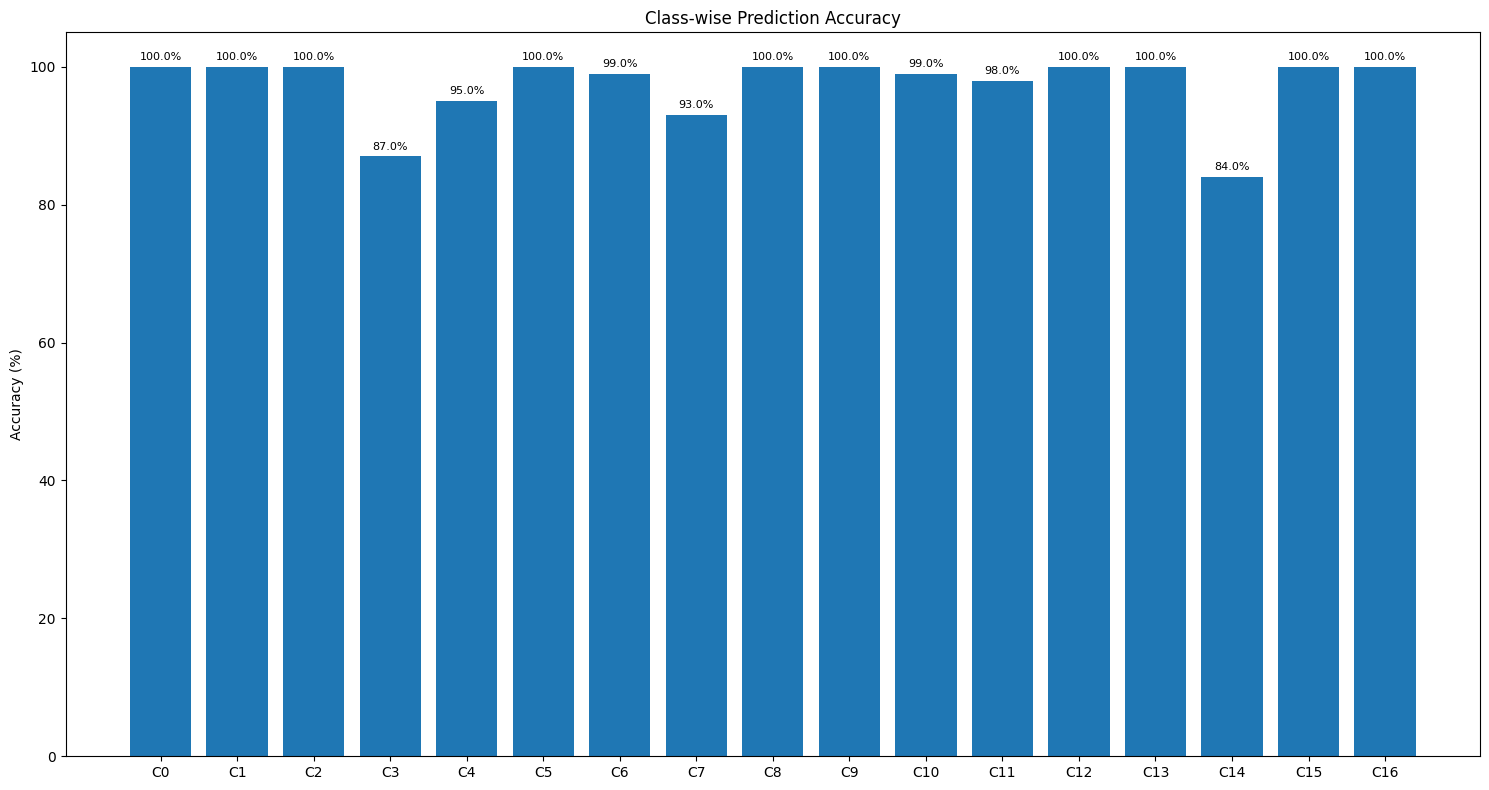

Worst 3 classes:
Class 14: 84.0%
Class 3: 87.0%
Class 7: 93.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("/root/home/cv_contest/CV_data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# # 디렉토리 생성
# os.makedirs('models', exist_ok=True)

# # fold_models 저장 (현재 메모리에 있다면 바로 실행 가능)
# print("Saving fold models...")
# for i, state_dict in enumerate(fold_models):
#     save_path = f'models/fold_{i+1}_best.pth'
#     torch.save(state_dict, save_path)  # 그냥 직접 저장
#     print(f"✓ Fold {i+1} model saved to {save_path}")

# print(f"All {len(fold_models)} fold models saved!")

In [14]:
# # 모델 저장 - 현재 상태 그대로 저장
# def save_models():
#     """학습한 모델들을 저장"""
    
#     # 저장 디렉토리 생성
#     save_dir = "models"
#     os.makedirs(save_dir, exist_ok=True)
    
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
#     print("🚨 모델 저장 시작...")
    
#     # 각 fold별 모델 저장 (fold_models 리스트가 있다고 가정)
#     try:
#         for fold in range(5):  # 5-fold라고 가정
#             model_path = f"{save_dir}/fold_{fold}_model_{timestamp}.pth"
            
#             # fold_models[fold]가 존재한다면 저장
#             if 'fold_models' in globals() and len(fold_models) > fold:
#                 torch.save({
#                     'model_state_dict': fold_models[fold].state_dict(),
#                     'fold': fold,
#                     'timestamp': timestamp,
#                     'epoch': 'unknown',  # 에포크 정보 모르면 unknown
#                 }, model_path)
#                 print(f"✅ Fold {fold} 모델 저장 완료: {model_path}")
            
#             # 또는 best_models 리스트가 있다면
#             elif 'best_models' in globals() and len(best_models) > fold:
#                 torch.save({
#                     'model_state_dict': best_models[fold].state_dict(),
#                     'fold': fold,
#                     'timestamp': timestamp,
#                     'epoch': 'unknown',
#                 }, model_path)
#                 print(f"✅ Fold {fold} best 모델 저장 완료: {model_path}")
                
#     except Exception as e:
#         print(f"❌ Fold별 저장 실패: {e}")
    
#     # 전체 변수 상태 저장 (혹시 모르니까)
#     try:
#         state_path = f"{save_dir}/full_state_{timestamp}.pth"
        
#         # 현재 글로벌 변수에서 모델 관련 객체들 찾아서 저장
#         save_dict = {}
        
#         # 가능한 모델 변수명들 체크
#         possible_model_vars = ['model', 'models', 'fold_models', 'best_models', 
#                               'tta_models', 'ensemble_models']
        
#         for var_name in possible_model_vars:
#             if var_name in globals():
#                 save_dict[var_name] = globals()[var_name]
#                 print(f"✅ {var_name} 변수 포함됨")
        
#         if save_dict:
#             torch.save(save_dict, state_path)
#             print(f"✅ 전체 상태 저장 완료: {state_path}")
        
#     except Exception as e:
#         print(f"❌ 전체 상태 저장 실패: {e}")
    
#     print(f"🎉 저장 완료! 저장 위치: {save_dir}/")
#     print(f"📁 파일 목록:")
#     for file in os.listdir(save_dir):
#         print(f"   - {file}")

In [15]:
# save_models()

In [16]:
# # 오답 데이터 분석 및 시각화
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np

# def analyze_wrong_predictions(model, val_loader, device, num_samples=20):
#     """오답 데이터 분석 및 시각화"""
#     model.eval()
#     wrong_predictions = []
    
#     with torch.no_grad():
#         for images, targets in val_loader:
#             images, targets = images.to(device), targets.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
            
#             # 오답인 샘플들 찾기
#             wrong_mask = (preds != targets)
#             wrong_indices = torch.where(wrong_mask)[0]
            
#             for idx in wrong_indices:
#                 wrong_predictions.append({
#                     'image': images[idx].cpu(),
#                     'true_class': targets[idx].cpu().item(),
#                     'pred_class': preds[idx].cpu().item(),
#                     'confidence': torch.softmax(outputs[idx], 0).max().cpu().item()
#                 })
                
#                 if len(wrong_predictions) >= num_samples:
#                     break
            
#             if len(wrong_predictions) >= num_samples:
#                 break
    
#     return wrong_predictions

# def visualize_wrong_predictions(wrong_predictions, class_names, rows=4, cols=5):
#     """오답 데이터 시각화"""
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
#     axes = axes.flatten()
    
#     for i, wrong_pred in enumerate(wrong_predictions[:rows*cols]):
#         if i >= len(axes):
#             break
            
#         # 이미지 전처리 (정규화 해제)
#         img = wrong_pred['image'].permute(1, 2, 0)
#         img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
#         img = torch.clamp(img, 0, 1)
        
#         axes[i].imshow(img)
#         axes[i].set_title(f"True: {wrong_pred['true_class']} | "
#                          f"Pred: {wrong_pred['pred_class']}\n"
#                          f"Conf: {wrong_pred['confidence']:.3f}", 
#                          fontsize=10)
#         axes[i].axis('off')
    
#     # 빈 subplot 제거
#     for i in range(len(wrong_predictions), len(axes)):
#         axes[i].remove()
    
#     plt.tight_layout()
#     plt.savefig('wrong_predictions_analysis.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def print_wrong_class_summary(wrong_predictions):
#     """오답 클래스 요약 출력"""
#     from collections import Counter
    
#     true_classes = [wp['true_class'] for wp in wrong_predictions]
#     pred_classes = [wp['pred_class'] for wp in wrong_predictions]
    
#     print("=== 오답 분석 요약 ===")
#     print("실제 클래스별 오답 빈도:")
#     true_counter = Counter(true_classes)
#     for class_id, count in sorted(true_counter.items()):
#         print(f"  클래스 {class_id}: {count}개 오답")
    
#     print("\n예측 클래스별 오답 빈도:")
#     pred_counter = Counter(pred_classes)
#     for class_id, count in sorted(pred_counter.items()):
#         print(f"  클래스 {class_id}로 오예측: {count}개")
    
#     print(f"\n총 분석된 오답 수: {len(wrong_predictions)}개")

# # 실행 코드
# print("오답 데이터 분석 시작...")

# # 현재 best 모델로 오답 분석 (Fold 1 기준)
# wrong_preds = analyze_wrong_predictions(best_model, val_loader, device, num_samples=20)

# # 오답 요약 출력
# print_wrong_class_summary(wrong_preds)

# # 오답 이미지 시각화
# visualize_wrong_predictions(wrong_preds, class_names=None, rows=4, cols=5)

# print("오답 분석 완료!")


🏁 K-FOLD ConvNeXt 강화 시스템 결과


NameError: name 'ACTIVE_MODELS' is not defined

In [29]:
# =============================================================================
# 📊 K-Fold 결과 분석 (단일 모델 버전)
# =============================================================================

print(f"\n{'='*60}")
print("🏁 K-FOLD 결과 상세 분석")
print(f"{'='*60}")

# 전체 성능 요약
val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

print(f"\n🤖 모델: {model_name}")
print(f"📊 평균 CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"🏆 최고 Fold: {max(val_f1_scores):.4f}")
print(f"📉 최악 Fold: {min(val_f1_scores):.4f}")
print(f"📏 성능 범위: {max(val_f1_scores) - min(val_f1_scores):.4f}")

# Fold별 상세 성능
print(f"\n📋 Fold별 상세 결과:")
print(f"{'📁 Fold':<8} {'🎯 Val F1':<10} {'📈 Train F1':<11} {'👥 Train':<8} {'✅ Val':<7}")
print("─" * 50)

for result in fold_results:
   print(f"   {result['fold']:<5} "
         f"   {result['best_val_f1']:<8.4f} "
         f"   {result['final_train_f1']:<9.4f} "
         f"   {result['train_samples']:<6} "
         f"   {result['val_samples']:<5}")

# 성능 순위
sorted_results = sorted(fold_results, key=lambda x: x['best_val_f1'], reverse=True)
print(f"\n🏅 성능 순위:")
medals = ["🥇", "🥈", "🥉", "🏅", "🏅"]
for i, result in enumerate(sorted_results):
   medal = medals[i] if i < len(medals) else "📍"
   print(f"{medal} {i+1}위: Fold {result['fold']} - F1: {result['best_val_f1']:.4f}")

# 클래스별 성능 분석
if fold_class_accuracies:
   print(f"\n🎯 클래스별 성능 분석:")
   print(f"{'📊 Class':<9} {'📈 평균':<8} {'📏 표준편차':<9} {'🏆 최고':<7} {'📉 최악':<7}")
   print("─" * 45)
   
   class_performance = []
   for class_id in range(17):
       class_accs = []
       for fold_acc in fold_class_accuracies:
           if class_id in fold_acc:
               class_accs.append(fold_acc[class_id])
       
       if class_accs:
           mean_acc = np.mean(class_accs)
           std_acc = np.std(class_accs)
           max_acc = max(class_accs)
           min_acc = min(class_accs)
           
           class_performance.append({
               'class_id': class_id,
               'mean_acc': mean_acc,
               'std_acc': std_acc,
               'max_acc': max_acc,
               'min_acc': min_acc
           })
           
           print(f"   {class_id:<5} "
                 f"   {mean_acc:<6.3f} "
                 f"   {std_acc:<7.3f} "
                 f"   {max_acc:<5.3f} "
                 f"   {min_acc:<5.3f}")
   
   # 어려운 클래스 TOP 3
   worst_classes = sorted(class_performance, key=lambda x: x['mean_acc'])[:3]
   print(f"\n🔴 가장 어려운 클래스 TOP 3:")
   for i, cls in enumerate(worst_classes, 1):
       print(f"   {i}. Class {cls['class_id']}: {cls['mean_acc']:.3f} 정확도")
   
   # 쉬운 클래스 TOP 3
   best_classes = sorted(class_performance, key=lambda x: x['mean_acc'], reverse=True)[:3]
   print(f"\n🟢 가장 쉬운 클래스 TOP 3:")
   for i, cls in enumerate(best_classes, 1):
       print(f"   {i}. Class {cls['class_id']}: {cls['mean_acc']:.3f} 정확도")

# 성능 일관성 분석
cv_coefficient = std_f1 / mean_f1 if mean_f1 > 0 else 0
print(f"\n⚖️ 성능 일관성 분석:")
print(f"📊 변동계수 (CV): {cv_coefficient:.3f}")

if cv_coefficient < 0.05:
   consistency_emoji = "🟢"
   consistency_text = "매우 일관적인 성능"
elif cv_coefficient < 0.1:
   consistency_emoji = "🔵"
   consistency_text = "일관적인 성능"
elif cv_coefficient < 0.15:
   consistency_emoji = "🟡"
   consistency_text = "보통 수준의 일관성"
else:
   consistency_emoji = "🔴"
   consistency_text = "성능 변동이 큼"

print(f"{consistency_emoji} {consistency_text}")

# 추가 통계
overfit_count = sum(1 for result in fold_results 
                  if result['final_train_f1'] - result['best_val_f1'] > 0.05)

print(f"\n📈 학습 상태 분석:")
print(f"🎯 과적합 의심 Fold: {overfit_count}/{len(fold_results)}개")
if overfit_count > 0:
   print(f"   💡 Train-Val F1 차이가 0.05 이상인 fold 수")

print(f"\n✅ 학습 완료! 총 {len(fold_results)}개 fold 모델 저장됨")
print(f"📁 저장된 모델 파일:")
for i, result in enumerate(fold_results, 1):
   print(f"   📄 {result['model_path']}")

print(f"\n🎉 K-Fold Cross Validation 분석 완료!")


🏁 K-FOLD 결과 상세 분석

🤖 모델: convnext_base_384_in22ft1k
📊 평균 CV F1: 0.9835 ± 0.0060
🏆 최고 Fold: 0.9941
📉 최악 Fold: 0.9766
📏 성능 범위: 0.0176

📋 Fold별 상세 결과:
📁 Fold   🎯 Val F1   📈 Train F1  👥 Train  ✅ Val  
──────────────────────────────────────────────────
   1        0.9766      0.8897       1256      314  
   2        0.9839      0.8874       1256      314  
   3        0.9941      0.8542       1256      314  
   4        0.9838      0.9039       1256      314  
   5        0.9793      0.8910       1256      314  

🏅 성능 순위:
🥇 1위: Fold 3 - F1: 0.9941
🥈 2위: Fold 2 - F1: 0.9839
🥉 3위: Fold 4 - F1: 0.9838
🏅 4위: Fold 5 - F1: 0.9793
🏅 5위: Fold 1 - F1: 0.9766

🎯 클래스별 성능 분석:
📊 Class   📈 평균     📏 표준편차    🏆 최고    📉 최악   
─────────────────────────────────────────────
   0        1.000     0.000      1.000    1.000
   1        1.000     0.000      1.000    1.000
   2        1.000     0.000      1.000    1.000
   3        0.870     0.068      0.950    0.750
   4        0.950     0.055      1.000    0.850


In [17]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [18]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [19]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [20]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [21]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "/root/home/cv_contest/CV_data/sample_submission.csv",
    "/root/home/cv_contest/CV_data/test",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=16,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [22]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [23]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 197/197 [17:24<00:00,  5.30s/it]


In [24]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [25]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("/root/home/cv_contest/CV_data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [26]:
# TTA 결과 저장
tta_pred_df.to_csv("/root/home/cv_contest/results/BH_512_base_TTA.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [27]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
